# scATAC-seq Advanced data analysis
##  1. 获取Peak Set

### 1.1 获取pseudo bulk重复样本
因为 scATAC-seq 数据本质上是二元的——这意味着任何单个基因座都可以开放或者是不开放的，基于在单个细胞上进行的peakcalling几乎上是不可能。此外，许多分析都需要重复才具有统计显着性。在单细胞ATAC数据中，我们通过创建 pseudo bulk 来解决这些问题。*pseudo-bulk*是指将来自同一组数据组合成一个类似于bulk ATAC-seq 实验的模拟样本。ArchR 为每个所需的细胞分组制作多个这样的pseudo bulk样本，这个过程的基本假设是，被组合在一起的单个细胞非常相似，因此不考虑它们之间的差异。
为了创建pseudo bulk 重复样本，ArchR 采用了决策树方法。需要指定 (i) 所需的最小和最大重复样本数，(ii) 每个模拟bulk样本的最小和最大细胞数，以及 (iii) 如果特定分组缺乏足够的细胞时，使用的不放回的随机抽样的方法获取pseudo bulk 样本时的采样率。例如，0.8 的采样率意味着对分组中总细胞进行不放回的随机抽样，每次抽取的细胞数最多可达总细胞数的80%。在这种情况下，将会导致多个重复样本中可能包含一些相同的细胞，但如果想从缺乏足够细胞的细胞组中生成pseudo bulk重复样本，这是必要的牺牲。

<center>
<img src="https://www.archrproject.com/bookdown/images/pseudobulkReplicate_DecisionTree.png" width="669">
</center>

首先，需要确定要使用的group——可以是Cluster 也可以是celltype。然后，对group中每一个Cluster/cell type，ArchR尝试创建所需的bulk ATAC-seq。理想的模拟bulk ATAC-seq样本将由单个样品中的足够数量的细胞组成。这保持了样本多样性和重复之间的生物学变化。实际上，在此过程中有5个可能的结果：
1. 数据拥有足够多的样本(至少要等于maxRep定义的重复)，且每个样本的细胞数都大于 minCell, 于是每个样本都可以作为拟混池重复，每个重复的细胞都来自于同一个样本。
2. 一些样本的细胞数超过minCell,因此能够单独形成一个重复。剩下的重复则是通过将余下的细胞进行混合，然后通过无放回抽样得到。
3. 数据里没有一个样本的细胞数超过minCell, 但是总细胞数超过minCells * minReps。因此将所有的细胞进行混合，然后进行无放回抽样，抽样时不考虑细胞来源。
4. 一个细胞分组中的总细胞数低于 minCells * minReps，但是大于minCells / Sample Ratio。此时单个样本的构建采取无放回抽样，重复间则需要有放回抽样，降低多个拟混池重复间的相同细胞数。
5. 一个细胞分组中的总细胞数低于 minCells / Sample Ratio 。这意味着我们必须在单个重复和跨重复中都采取有放回抽样策略。这是最糟糕的情况，后续在使用这些模拟的bulk样本做下游分析分析要特别小心。后续可以通过设置ArchR的minCells参数进行淘汰。

为了说明此过程，我们将使用以下示例数据集：


| Sample | Cluster1 | Cluster2 | Cluster3 | Cluster4 | Cluster5 |
|--------|----------|----------|----------|----------|----------|
| A      | 800      | 600      | 900      | 100      | 75       |
| B      | 1000     | 50       | 400      | 150      | 25       |
| C      | 600      | 900      | 100      | 200      | 50       |
| D      | 1200     | 500      | 50       | 50       | 25       |
| E      | 900      | 100      | 50       | 150      | 50       |
| F      | 700      | 200      | 100      | 100      | 25       |



 设置minRep = 3，maxRep = 5, minCells = 300,maxCells = 1000，sampleRatio = 0.8

**Cluster1**

对于Cluster 1，我们有6个样品（超过maxRep），所有样本都比minCells细胞（300个单元）更多。这说明了上面的选项＃1，我们将以示例意识的方式进行5个模拟bulk ATAC-seq：

* Rep1 = 800 cells from SampleA
* Rep2 = 1000 cells from SampleB
* Rep3 = 1000 cells from SampleD
* Rep4 = 900 cells from SampleE
* Rep5 = 700 cells from SampleF

关于这些重复的有两件事要注意：（i）被排除在外，因为我们有足够多的样品来使maxRep样品吸引的伪bulk-seq，而SampleC的细胞数量最少。（ii）从采样中仅使用了1000个单元，因为这是maxCells值。


**Cluster2**

对于cluster2，我们有3个样品，所有样本都比minCells细胞多，还有一些其他样品。这说明了上面的选项＃2，我们将进行以下伪bulk重复：

* Rep1 = 600 cells from SampleA
* Rep2 = 900 cells from SampleC
* Rep3 = 500 cells from SampleD
* Rep4 = 350 cells [50 cells from SampleB + 100 from SampleE + 200 from SampleF]

在此示例中，Rep4通过不放回抽样的方式创建。

**Cluster3**

对于cluster3，我们只有2个样品，这些样品的minCells细胞大于所需的细胞minReps。但是，如果我们将剩余样品中的单元组合在一起，则可以使一个额外的复制量超过minCells。这为我们提供了总共3个伪蓝色复制，并表示上面选项3所示的情况。我们将进行以下重复：

* Rep1 = 900 cells from SampleA
* Rep2 = 400 cells from SampleB
* Rep3 = 250 cells [100 cells from SampleC + 50 from SampleD + 50 from SampleE + 50 from SampleF]

与上面的cluster2相似，cluster3 rep3是通过样本不可知的方式创建的，而无需替换多个样本。

**Cluster4**

对于Cluster4，细胞总数为750，小于minCells * minReps（900个单元）。minReps在这种情况下，至少minCells没有某种形式的采样，我们没有足够的细胞来制作。但是，总细胞仍然大于minCells / sampleRatio（375个细胞），这意味着我们只需要在不同的伪膨化重复中进行替换，而不是在单个复制中进行采样。这表示上面选项4中所示的情况，因此我们将进行以下重复：

* Rep1 = 300 cells [250 unique cells + 25 cells overlapping Rep2 + 25 cells overlapping Rep3]
* Rep2 = 300 cells [250 unique cells + 25 cells overlapping Rep1 + 25 cells overlapping Rep3]
* Rep3 = 300 cells [250 unique cells + 25 cells overlapping Rep1 + 25 cells overlapping Rep2]
 
 在这种情况下，ARCHR将最大程度地减少任何两个伪卵形复制之间重叠的单元数量。

**Cluster 5**

对于Cluster5，细胞总数为250，小于minCells * minReps（900个细胞），小于minCells / sampleRatio（375个细胞）。这意味着我们必须在每个样本中和跨不同的重复次数中进行替换，以进行伪块复制。这代表了上面选项5中所示的最不可取的情况，因此，我们应该在下游分析中使用这些伪膨胀重复。因此，我们将进行以下重复：


* Rep1 = 300 cells [250 unique cells + 25 cells overlapping Rep2 + 25 cells overlapping Rep3]
* Rep2 = 300 cells [250 unique cells + 25 cells overlapping Rep1 + 25 cells overlapping Rep3]
* Rep3 = 300 cells [250 unique cells + 25 cells overlapping Rep1 + 25 cells overlapping Rep2]

In [19]:
library(ArchR)
library(parallel)
library(Seurat)

library(pryr) 
addArchRThreads(threads = 10)
set.seed(1)
addArchRGenome("hg38")
library(BSgenome.Hsapiens.UCSC.hg38)

Setting default number of Parallel threads to 10.

Setting default genome to Hg38.

Loading required package: BSgenome

Loading required package: rtracklayer



In [23]:
# 读入做完细胞类型注释的ArchR object

setwd("/shared-data/")
proj <- readRDS("proj.rds")
setwd('/home/jovyan')

In [24]:
proj


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /home/jovyan/tutorial 
samples(1): 0607-ATAC-PBMC-ZYH-0302-2
sampleColData names(1): ArrowFiles
cellColData names(19): Sample TSSEnrichment ... predictedsubGroup
  predictedsubScore
numberOfCells(1): 6164
medianTSS(1): 22.262
medianFrags(1): 6203.5

In [25]:
proj$celltype <- proj$predictedsubGroup
table(proj$celltype)


           B   CD14+ Mono        CD8 T FCGR3A+ Mono Memory CD4 T           NA 
         390          334         1313            4          617            9 
 Naive CD4 T           NK     Platelet 
        1895         1554           48 

In [30]:
valid_celltype <- names(table(proj$celltype)[table(proj$celltype) > 100])
valid_celltype
proj <- proj[which(proj$celltype  %in% valid_celltype),]
proj

[1] "B"            "CD14+ Mono"   "CD8 T"        "Memory CD4 T" "Naive CD4 T" 
[6] "NK"

Dropping ImputeWeights Since You Are Subsetting Cells! ImputeWeights is a cell-x-cell Matrix!


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /home/jovyan/tutorial 
samples(1): 0607-ATAC-PBMC-ZYH-0302-2
sampleColData names(1): ArrowFiles
cellColData names(20): Sample TSSEnrichment ... predictedsubScore
  celltype
numberOfCells(1): 6103
medianTSS(1): 22.286
medianFrags(1): 6188

In [31]:
proj <- addGroupCoverages(
  ArchRProj = proj ,
  groupBy = "celltype",
  minRep=3,
  useLabels = TRUE,
  force = TRUE,
  threads = 1
)

ArchR logging to : ArchRLogs/ArchR-addGroupCoverages-45f1fd2182f-Date-2022-08-24_Time-02-54-48.log
If there is an issue, please report to github with logFile!

B (1 of 6) : CellGroups N = 2

CD8 T (2 of 6) : CellGroups N = 2

CD14+ Mono (3 of 6) : CellGroups N = 2

Memory CD4 T (4 of 6) : CellGroups N = 2

Naive CD4 T (5 of 6) : CellGroups N = 2

NK (6 of 6) : CellGroups N = 2

2022-08-24 02:54:48 : Creating Coverage Files!, 0.008 mins elapsed.

2022-08-24 02:54:48 : Batch Execution w/ safelapply!, 0.008 mins elapsed.

2022-08-24 02:54:48 : Group B._.Rep1 (1 of 12) : Creating Group Coverage File : B._.Rep1.insertions.coverage.h5, 0.008 mins elapsed.

Number of Cells = 310

Coverage File Exists!

Added Coverage Group

Added Metadata Group

Added ArrowCoverage Class

Added Coverage/Info

Added Coverage/Info/CellNames

2022-08-24 02:55:11 : Group B._.Rep2 (2 of 12) : Creating Group Coverage File : B._.Rep2.insertions.coverage.h5, 0.393 mins elapsed.

Number of Cells = 80

Coverage File Ex

### 1.2 peak set 确定

ArchR 选用501-bp的等宽peak，原因：
1.  下游处理不再需要根据peak宽度进行标准化从而简化了计算
2.  ATAC-seq的大部分peak宽度都低于501-bp。如果使用不定宽peak，后续不同样本的peak合并就会变得特别复杂

不同peak合并方法：
- 有1bp以上overlap就合并(`bedtools merge`)

<img src="https://www.archrproject.com/bookdown/images/peakCalling_RawOverlap.png" width="439">

- 重叠区域选取显著性最高作为最终peak(`bedtools cluster`)

<img src="https://www.archrproject.com/bookdown/images/peakCalling_ClusteredOverlap.png" width="439">

- 首先按peak显著性排名。第一步，删除显著性最高的peak有overlap的peak；第二步，比较余下peak显著性排名第二的peak，删除与其有overlap的部分，以此类推，保留没有overlap的peak

<img src="https://s2.loli.net/2022/08/17/82vcBhHXlUQ9Jkg.png"  width="439">

三种策略的比较

<img src="https://www.archrproject.com/bookdown/images/peakCalling_Comparison.png" width="439">


In [32]:

pathToMacs2 <- findMacs2()
proj <- addReproduciblePeakSet(
    ArchRProj = proj,
    groupBy = "celltype",
    cutOff = 0.1,
    pathToMacs2 = pathToMacs2,
    #genomeAnnotation = genomeAnnotation,
    #geneAnnotation = geneAnnotation,
    #genomeSize = 2.5e9,
    maxPeaks = 150000,
    force = TRUE
)
# 如果是自己生成的genomeAnnotation与geneAnnotation，需要genomeAnnotation与geneAnnotation加入两个参数；
# maxPeaks = 1500000,设置之后如果peak数超过该阈值，将会保留top maxPeaks数目，默认为 150000

Searching For MACS2..

Found with $path!

ArchR logging to : ArchRLogs/ArchR-addReproduciblePeakSet-45f11a94b1c-Date-2022-08-24_Time-03-03-48.log
If there is an issue, please report to github with logFile!

Calling Peaks with Macs2

2022-08-24 03:03:48 : Peak Calling Parameters!, 0.002 mins elapsed.



                    Group nCells nCellsUsed nReplicates nMin nMax maxPeaks
B                       B    390        390           2   80  310   150000
CD8 T               CD8 T   1313        580           2   80  500   150000
CD14+ Mono     CD14+ Mono    334        334           2   80  254   150000
Memory CD4 T Memory CD4 T    617        580           2   80  500   150000
Naive CD4 T   Naive CD4 T   1895        580           2   80  500   150000
NK                     NK   1554        580           2   80  500   150000


2022-08-24 03:03:48 : Batching Peak Calls!, 0.002 mins elapsed.

2022-08-24 03:03:48 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-08-24 03:05:07 : Identifying Reproducible Peaks!, 1.307 mins elapsed.

2022-08-24 03:05:11 : Creating Union Peak Set!, 1.386 mins elapsed.

Converged after 4 iterations!

Plotting Ggplot!

2022-08-24 03:05:16 : Finished Creating Union Peak Set (95289)!, 1.465 mins elapsed.



### 1.3 添加PeakMatrix到ArrowFiles中

In [33]:
proj <- addPeakMatrix(proj)

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-45f6e2ed86b-Date-2022-08-24_Time-03-05-16.log
If there is an issue, please report to github with logFile!

2022-08-24 03:05:16 : Batch Execution w/ safelapply!, 0 mins elapsed.

.createArrowGroup : Arrow Group already exists! Dropping Group from ArrowFile! This will take ~10-30 seconds!

.dropGroupsFromArrow : Initializing Temp ArrowFile

.dropGroupsFromArrow : Adding Metadata to Temp ArrowFile

.dropGroupsFromArrow : Adding SubGroups to Temp ArrowFile

.dropGroupsFromArrow : Move Temp ArrowFile to ArrowFile

2022-08-24 03:05:29 : Adding 0607-ATAC-PBMC-ZYH-0302-2 to PeakMatrix for Chr (1 of 23)!, 0.005 mins elapsed.

2022-08-24 03:05:33 : Adding 0607-ATAC-PBMC-ZYH-0302-2 to PeakMatrix for Chr (2 of 23)!, 0.074 mins elapsed.

2022-08-24 03:05:36 : Adding 0607-ATAC-PBMC-ZYH-0302-2 to PeakMatrix for Chr (3 of 23)!, 0.13 mins elapsed.

2022-08-24 03:05:39 : Adding 0607-ATAC-PBMC-ZYH-0302-2 to PeakMatrix for Chr (4 of 23)!, 0.18 mins elapsed.

### 1.4 自定义peak set 

In [ ]:
#Proj <- addPeakSet() 

### 1.5 获取每种cluster/celltype特异的marker peaks

获取每个cluster/celltype 特有的peak

In [22]:
library(parallel)

In [34]:
markersPeaks <- getMarkerFeatures(
   ArchRProj = proj,
   useMatrix = "PeakMatrix",
   groupBy = "celltype",
   bias = c("TSSEnrichment", "log10(nFrags)"),
   testMethod = "wilcoxon"
)

markerList <- getMarkers(markersPeaks, cutOff = "FDR <= 0.01 & Log2FC >= 1")
#saveRDS(markerList,"marker_peaks_list.rds")

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-45f89d940e-Date-2022-08-24_Time-03-10-40.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Integer.Matrix

2022-08-24 03:10:41 : Matching Known Biases, 0.002 mins elapsed.

###########
2022-08-24 03:11:07 : Completed Pairwise Tests, 0.439 mins elapsed.
###########

ArchR logging successful to : ArchRLogs/ArchR-getMarkerFeatures-45f89d940e-Date-2022-08-24_Time-03-10-40.log



### 1.6 获取两两cluster，或者两两celltype之间的差异peak

In [35]:
markerTest <- getMarkerFeatures(
  ArchRProj = proj, 
  useMatrix = "PeakMatrix",
  groupBy = "celltype",
  testMethod = "wilcoxon",
  bias = c("TSSEnrichment", "log10(nFrags)"),
  useGroups = "CD14+ Mono",
  bgdGroups = "B"
)


ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-45f47869e0b-Date-2022-08-24_Time-03-11-56.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Integer.Matrix

2022-08-24 03:11:56 : Matching Known Biases, 0.002 mins elapsed.

2022-08-24 03:11:57 : Computing Pairwise Tests (1 of 1), 0.018 mins elapsed.

Pairwise Test CD14+ Mono : Seqnames chr1

Pairwise Test CD14+ Mono : Seqnames chr10

Pairwise Test CD14+ Mono : Seqnames chr11

Pairwise Test CD14+ Mono : Seqnames chr12

Pairwise Test CD14+ Mono : Seqnames chr13

Pairwise Test CD14+ Mono : Seqnames chr14

Pairwise Test CD14+ Mono : Seqnames chr15

Pairwise Test CD14+ Mono : Seqnames chr16

Pairwise Test CD14+ Mono : Seqnames chr17

Pairwise Test CD14+ Mono : Seqnames chr18

Pairwise Test CD14+ Mono : Seqnames chr19

Pairwise Test CD14+ Mono : Seqnames chr2

Pairwise Test CD14+ Mono : Seqnames chr20

Pairwise Test CD14+ Mono : Seqnames chr21

Pairwise Test CD14+ Mono : Seqnames chr22

Pairwise Test CD

Warning message:
“'markerPlot' is deprecated.
Use 'plotMarkers' instead.
See help("Deprecated")”
Warning message:
“Removed 30 rows containing missing values (geom_point_rast).”
Warning message:
“'markerPlot' is deprecated.
Use 'plotMarkers' instead.
See help("Deprecated")”
Warning message:
“Removed 30 rows containing missing values (geom_point_rast).”


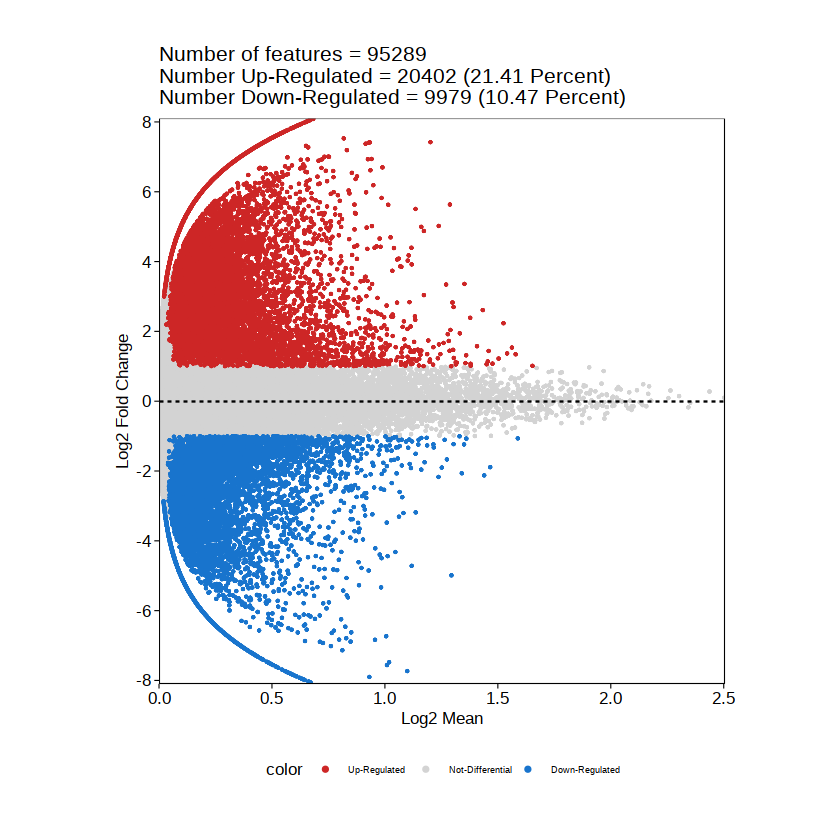

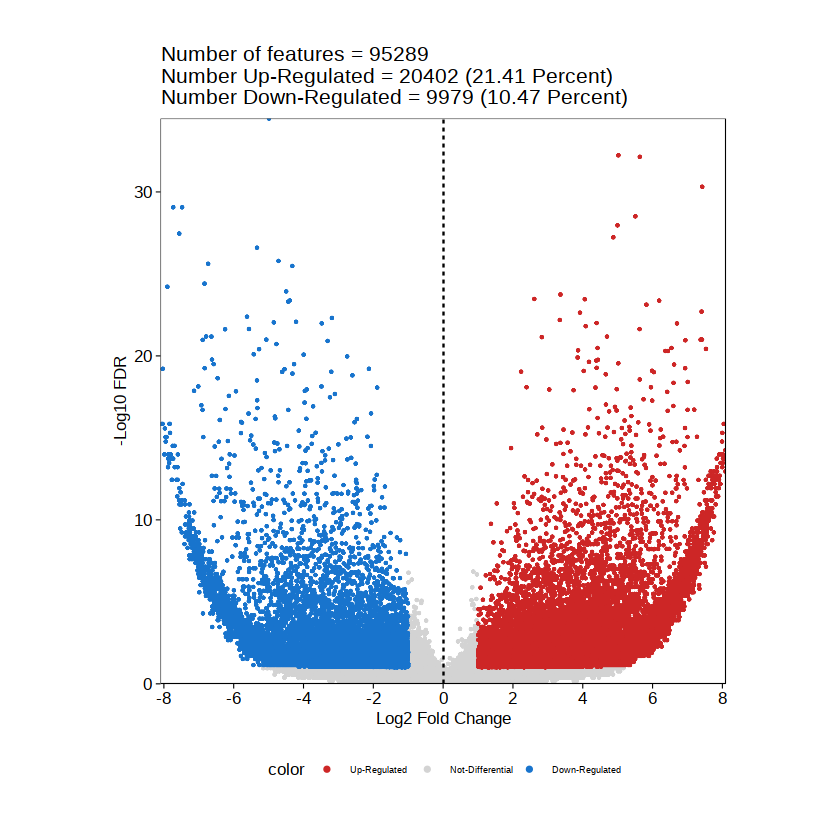

In [37]:
#绘制MA图
pma <- markerPlot(seMarker = markerTest, name = "CD14+ Mono", cutOff = "FDR <= 0.1 & abs(Log2FC) >= 1", plotAs = "MA")
pma
#绘制火山图
pv <- markerPlot(seMarker = markerTest, name = "CD14+ Mono", cutOff = "FDR <= 0.1 & abs(Log2FC) >= 1", plotAs = "Volcano")
pv

## 2. 获取motif Annotation

在确定了一个PeakSet后，我们经常想要预测哪些转录因子可能会介导产生那些可访问染色质位点的结合事件。这有助于评估标记峰或差异峰，以了解这些峰组是否富含特定转录因子的结合位点。例如，我们经常发现在细胞类型特异性可接近的染色质区域中，关键谱系定义 TF 的富集。以类似的方式，我们可能想要测试各种峰组以丰富其他已知特征。例如，我们可能想知道细胞类型 A 的细胞类型特异性peak是否富含另一组基因组区域，例如 ChIP-seq 峰。本章详细介绍了如何在 ArchR 中执行这些扩充

In [39]:
proj <- addMotifAnnotations(ArchRProj = proj, motifSet = "cisbp", name = "Motif")

ArchR logging to : ArchRLogs/ArchR-addMotifAnnotations-45f59daec28-Date-2022-08-24_Time-03-30-00.log
If there is an issue, please report to github with logFile!

2022-08-24 03:30:00 : Gettting Motif Set, Species : Homo sapiens, 0.001 mins elapsed.

Using version 2 motifs!

2022-08-24 03:30:02 : Finding Motif Positions with motifmatchr!, 0.03 mins elapsed.

2022-08-24 03:32:26 : Filtering Motif Annotations with 0 overlaps :

 ENSG00000250542_156

, 2.433 mins elapsed.

2022-08-24 03:32:26 : Creating Motif Overlap Matrix, 2.434 mins elapsed.

2022-08-24 03:32:28 : Finished Getting Motif Info!, 2.474 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-addMotifAnnotations-45f59daec28-Date-2022-08-24_Time-03-30-00.log



### 2.1 在差异peaks中motif的富集

In [40]:
motifsUp <- peakAnnoEnrichment(
    seMarker = markerTest,
    ArchRProj = proj,
    peakAnnotation = "Motif",
    cutOff = "FDR <= 0.1 & Log2FC >= 0.5"
  )


ArchR logging to : ArchRLogs/ArchR-peakAnnoEnrichment-45f437a914b-Date-2022-08-24_Time-04-18-16.log
If there is an issue, please report to github with logFile!

2022-08-24 04:18:19 : Computing Enrichments 1 of 1, 0.054 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-peakAnnoEnrichment-45f437a914b-Date-2022-08-24_Time-04-18-16.log



peakAnnoEnrichment() 的输出是一个 `SummarizedExperiment `包含多个`assays`，这些assays中存储着超几何富集的结果

In [41]:
motifsUp

class: SummarizedExperiment 
dim: 869 1 
metadata(0):
assays(10): mlog10Padj mlog10p ... CompareFrequency feature
rownames(869): TFAP2B_1 TFAP2D_2 ... TBX18_869 TBX22_870
rowData names(0):
colnames(1): CD14+ Mono
colData names(0):

然后，我们创建一个data.frame对象用于ggplot作图，包括motif名，矫正的p值和显著性排序

In [42]:
df <- data.frame(TF = rownames(motifsUp), mlog10Padj = assay(motifsUp)[,1])
df <- df[order(df$mlog10Padj, decreasing = TRUE),]
df$rank <- seq_len(nrow(df))

head(df)

,TF,mlog10Padj,rank
,<chr>,<dbl>,<int>
335,SPIB_336,630.8476,1
155,CEBPA_155,559.2323,2
321,SPI1_322,538.5851,3
140,CEBPB_140,488.0841,4
152,CEBPD_152,434.6041,5
139,JUNB_139,355.3715,6


使用ggplot展示结果，以ggrepel来标识每个TF motif名。

Warning message:
“ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


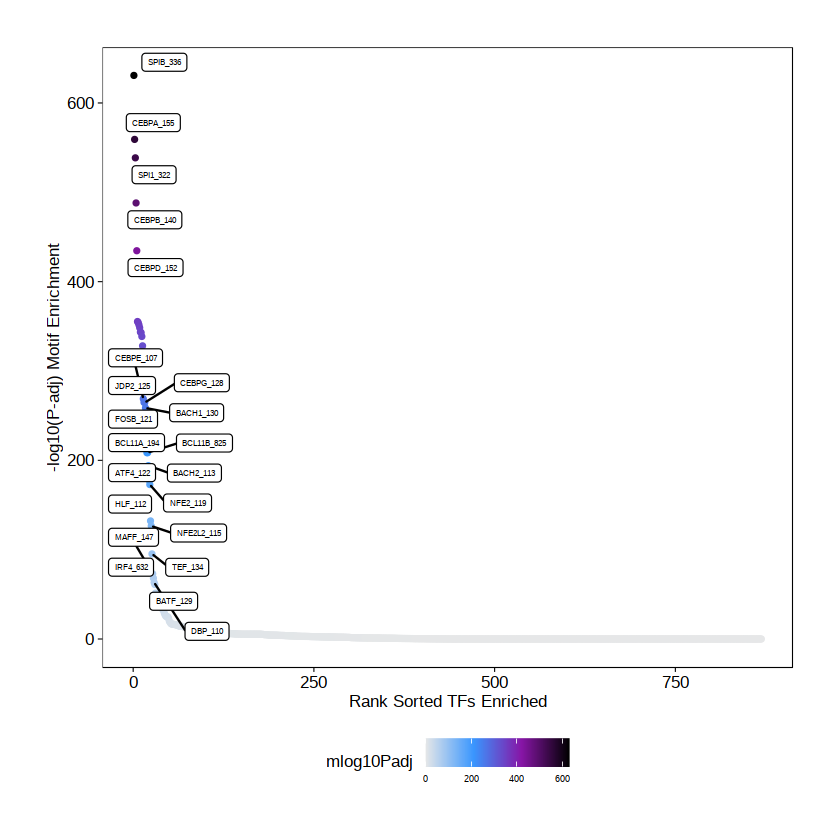

In [43]:

ggUp <- ggplot(df, aes(rank, mlog10Padj, color = mlog10Padj)) + 
  geom_point(size = 1) +
  ggrepel::geom_label_repel(
        data = df[rev(seq_len(30)), ], aes(x = rank, y = mlog10Padj, label = TF), 
        size = 1.5,
        nudge_x = 2,
        color = "black"
  ) + theme_ArchR() + 
  ylab("-log10(P-adj) Motif Enrichment") + 
  xlab("Rank Sorted TFs Enriched") +
  scale_color_gradientn(colors = paletteContinuous(set = "comet"))

ggUp

通过设置Log2FC <= -0.5我们可以挑选出在"Progenitor"里更加开放的peak，然后分析其中富集的motif。

ArchR logging to : ArchRLogs/ArchR-peakAnnoEnrichment-45f6ccbbbcb-Date-2022-08-24_Time-04-18-58.log
If there is an issue, please report to github with logFile!

2022-08-24 04:19:01 : Computing Enrichments 1 of 1, 0.052 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-peakAnnoEnrichment-45f6ccbbbcb-Date-2022-08-24_Time-04-18-58.log



class: SummarizedExperiment 
dim: 869 1 
metadata(0):
assays(10): mlog10Padj mlog10p ... CompareFrequency feature
rownames(869): TFAP2B_1 TFAP2D_2 ... TBX18_869 TBX22_870
rowData names(0):
colnames(1): CD14+ Mono
colData names(0):

Warning message:
“ggrepel: 20 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


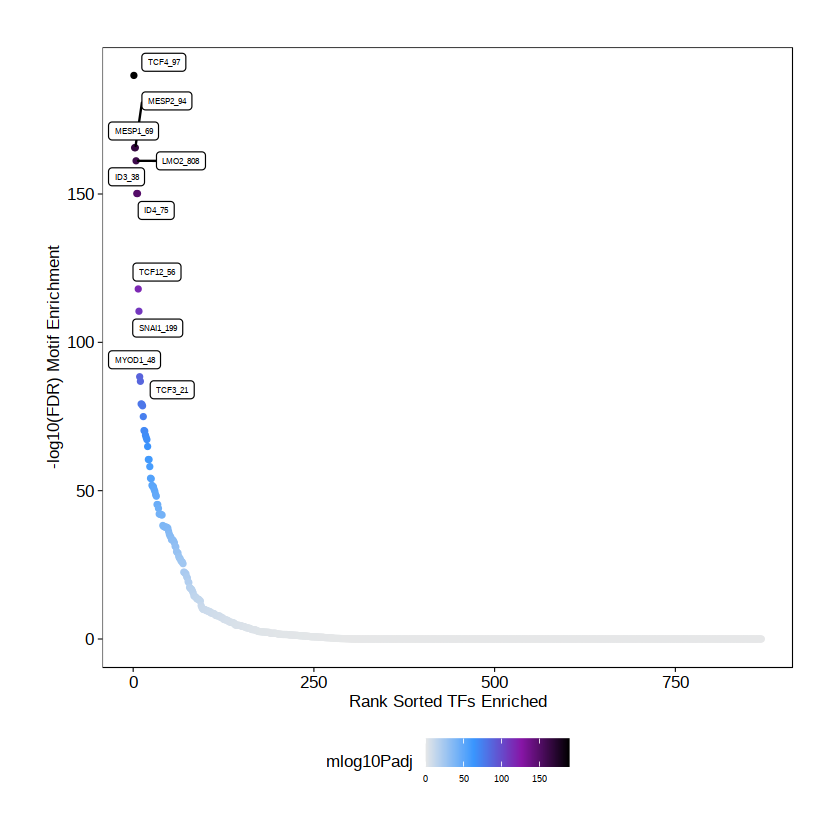

In [45]:
motifsDo <- peakAnnoEnrichment(
    seMarker = markerTest,
    ArchRProj = proj,
    peakAnnotation = "Motif",
    cutOff = "FDR <= 0.1 & Log2FC <= -0.5"
  )
motifsDo

df <- data.frame(TF = rownames(motifsDo), mlog10Padj = assay(motifsDo)[,1])
df <- df[order(df$mlog10Padj, decreasing = TRUE),]
df$rank <- seq_len(nrow(df))



ggDo <- ggplot(df, aes(rank, mlog10Padj, color = mlog10Padj)) + 
  geom_point(size = 1) +
  ggrepel::geom_label_repel(
        data = df[rev(seq_len(30)), ], aes(x = rank, y = mlog10Padj, label = TF), 
        size = 1.5,
        nudge_x = 2,
        color = "black"
  ) + theme_ArchR() + 
  ylab("-log10(FDR) Motif Enrichment") +
  xlab("Rank Sorted TFs Enriched") +
  scale_color_gradientn(colors = paletteContinuous(set = "comet"))

ggDo

### 2.2 在细胞类型特异的peak中motif的富集

ArchR logging to : ArchRLogs/ArchR-peakAnnoEnrichment-45fb8de5b4-Date-2022-08-24_Time-04-25-53.log
If there is an issue, please report to github with logFile!

2022-08-24 04:25:56 : Computing Enrichments 1 of 6, 0.056 mins elapsed.

2022-08-24 04:25:56 : Computing Enrichments 2 of 6, 0.06 mins elapsed.

2022-08-24 04:25:57 : Computing Enrichments 3 of 6, 0.063 mins elapsed.

2022-08-24 04:25:57 : Computing Enrichments 4 of 6, 0.068 mins elapsed.

2022-08-24 04:25:57 : Computing Enrichments 5 of 6, 0.071 mins elapsed.

2022-08-24 04:25:57 : Computing Enrichments 6 of 6, 0.075 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-peakAnnoEnrichment-45fb8de5b4-Date-2022-08-24_Time-04-25-53.log



class: SummarizedExperiment 
dim: 869 6 
metadata(0):
assays(10): mlog10Padj mlog10p ... CompareFrequency feature
rownames(869): TFAP2B_1 TFAP2D_2 ... TBX18_869 TBX22_870
rowData names(0):
colnames(6): B CD8 T ... Naive CD4 T NK
colData names(0):

ArchR logging to : ArchRLogs/ArchR-plotEnrichHeatmap-45f5f98c668-Date-2022-08-24_Time-04-25-58.log
If there is an issue, please report to github with logFile!

Adding Annotations..

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



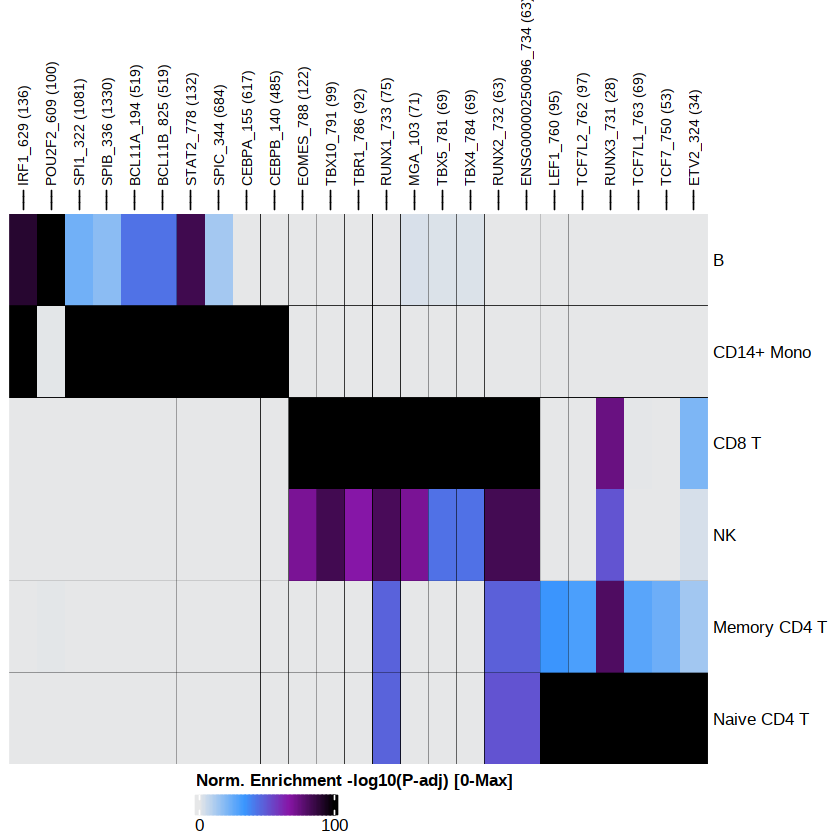

In [48]:
enrichMotifs <- peakAnnoEnrichment(
    seMarker = markersPeaks,
    ArchRProj = proj,
    peakAnnotation = "Motif",
    cutOff = "FDR <= 0.1 & Log2FC >= 0.5"
  )

enrichMotifs

heatmapEM <- plotEnrichHeatmap(enrichMotifs, n = 7, transpose = TRUE)
ComplexHeatmap::draw(heatmapEM, heatmap_legend_side = "bot", annotation_legend_side = "bot")

## 3. 用ChromVAR进行motif偏离富集分析

TF 基序富集可以帮助我们预测哪些调节因子在我们感兴趣的细胞类型中最活跃。然而，这些富集不是基于每个细胞计算的，也没有考虑到 Tn5 转座酶的插入序列偏差。为解决此问题，Greenlead Lab开发R包chromVAR根据稀疏的染色质可及性数据预测每个细胞的 TF 活性富集。chromVAR 的两个主要输出是：

"deciations" - 偏差是对给定特征（即motif）的每个细胞开放性性与基于细胞或者样本的平均值的预期开放性偏离的偏差校正值。
"Z-score" - 也称为“偏差分数”，是所有单元格中每个偏差校正偏差的 z 分数。偏差分数的绝对值与每个细胞的reads的深度相关。这是因为，reads数越多，就越有信心相信motif的每个单元格可访问性与预期的差异大于偶然发生的差异。
chromVAR 的主要限制之一是它是在 scATAC-seq 数据生成的早期设计的，当时实验由几百个细胞组成。在这个实验规模下，chromVAR 可以轻松地将整个cell-peak矩阵读取到内存中，以快速计算 TF 偏差。然而，当细胞数目达到数万数百万级别时，很难将peak-cell矩阵读入。对于 50,000 个细胞大小的数据集都会导致运行时间和内存使用量的显著增加。

chromVAR流程：

<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fnmeth.4401/MediaObjects/41592_2017_BFnmeth4401_Fig4_ESM.jpg?as=webp">

为了规避这些限制，ArchR 通过独立分析样本子矩阵来实现相同的 chromVAR 分析工作流程。

<img src="https://www.archrproject.com/bookdown/images/ArchR_chromVAR_Parallelization.png"  width="439">


首先，确定已经在proj中添加motif annotation

In [49]:
if("Motif" %ni% names(proj@peakAnnotation)){
    proj <- addMotifAnnotations(ArchRProj = proj, motifSet = "cisbp", name = "Motif")
}
# motifset

此外，我们还需要添加一组background peak用于计算偏离。background peak通过chromVAR::getBackgroundPeaks()函数进行选择，该函数根据根据GC含量相似性和样本中的fragment数计算马氏距离然后对peak进行抽样。


In [50]:
proj <- addBgdPeaks(proj)

Identifying Background Peaks!




接下来，就可以使用addDeviatonMatrix()函数根据所有的motif注释计算每个细胞的偏离值。该函数有一个可选参数matrixName，用于定义该偏离值矩阵在Arrow文件里的名字。在下面的例子，函数会以"peakAnnotation"里设置的参数为基础，额外在后面添加字符串"Matrix"，因此下面函数运行结束后会为每个Arrow文件都创建了一个"MotifMatrix"的偏离值矩阵


In [51]:
proj <- addDeviationsMatrix(
  ArchRProj = proj, 
  peakAnnotation = "Motif",
  force = TRUE
)

Using Previous Background Peaks!

ArchR logging to : ArchRLogs/ArchR-addDeviationsMatrix-45f4d75f47f-Date-2022-08-24_Time-04-26-57.log
If there is an issue, please report to github with logFile!



NULL


2022-08-24 04:26:59 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-08-24 04:27:00 : chromVAR deviations 0607-ATAC-PBMC-ZYH-0302-2 (1 of 1) Schep (2017), 0.019 mins elapsed.

2022-08-24 04:27:58 : 0607-ATAC-PBMC-ZYH-0302-2 (1 of 1) : Deviations for Annotation 43 of 869, 0.801 mins elapsed.

2022-08-24 04:28:41 : 0607-ATAC-PBMC-ZYH-0302-2 (1 of 1) : Deviations for Annotation 86 of 869, 1.519 mins elapsed.

2022-08-24 04:29:22 : 0607-ATAC-PBMC-ZYH-0302-2 (1 of 1) : Deviations for Annotation 129 of 869, 2.209 mins elapsed.

2022-08-24 04:30:17 : 0607-ATAC-PBMC-ZYH-0302-2 (1 of 1) : Deviations for Annotation 172 of 869, 3.121 mins elapsed.

2022-08-24 04:31:21 : 0607-ATAC-PBMC-ZYH-0302-2 (1 of 1) : Deviations for Annotation 215 of 869, 4.181 mins elapsed.

2022-08-24 04:32:20 : 0607-ATAC-PBMC-ZYH-0302-2 (1 of 1) : Deviations for Annotation 258 of 869, 5.167 mins elapsed.

2022-08-24 04:33:10 : 0607-ATAC-PBMC-ZYH-0302-2 (1 of 1) : Deviations for Annotation 301 of 869, 6.007 mins ela

使用getVarDeviations()函数提取这些偏离值矩阵。如果需要它返回一个ggplot对象，那么只需要设置plot=TRUE即可，函数会返回一个DataFrame对象。函数运行后，会默认展示该DataFrame对象的前几行。

In [52]:
plotVarDev <- getVarDeviations(proj, name = "MotifMatrix", plot = TRUE)

DataFrame with 6 rows and 6 columns
     seqnames     idx      name combinedVars combinedMeans      rank
        <Rle> <array>   <array>    <numeric>     <numeric> <integer>
f335        z     335  SPIB_336      27.0488     -0.324648         1
f321        z     321  SPI1_322      16.8260     -0.241240         2
f155        z     155 CEBPA_155      16.0397     -0.271544         3
f124        z     124  JUND_124      15.9445     -0.134996         4
f139        z     139  JUNB_139      15.4794     -0.130890         5
f142        z     142 FOSL1_142      15.3420     -0.113450         6


从上面DataFrame的输出信息中，可以发现MotifMatrix的seqnames并不是chromosome(染色体名)。通常而言，TileMatrix, PeakMatrix, GeneScoreMatrix，seqnames中记录均是染色体信息。MotifMatrix并没有任何对应的位置信息，而是会在相同的矩阵里记录chromVAR输出的"devations"和"z-scores"信息，即deviations和z。如果后续想在getMarkerFeatures()这类函数中使用MotifMatrix(Sparse.Assays.Matrix类)的话，那么这些信息就是非常重要的。在这类操作中，ArchR会希望你从MotifMatrix提取其中一个seqnames(例如，选择z-scores或deviations执行计算)

Warning message:
“ggrepel: 16 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


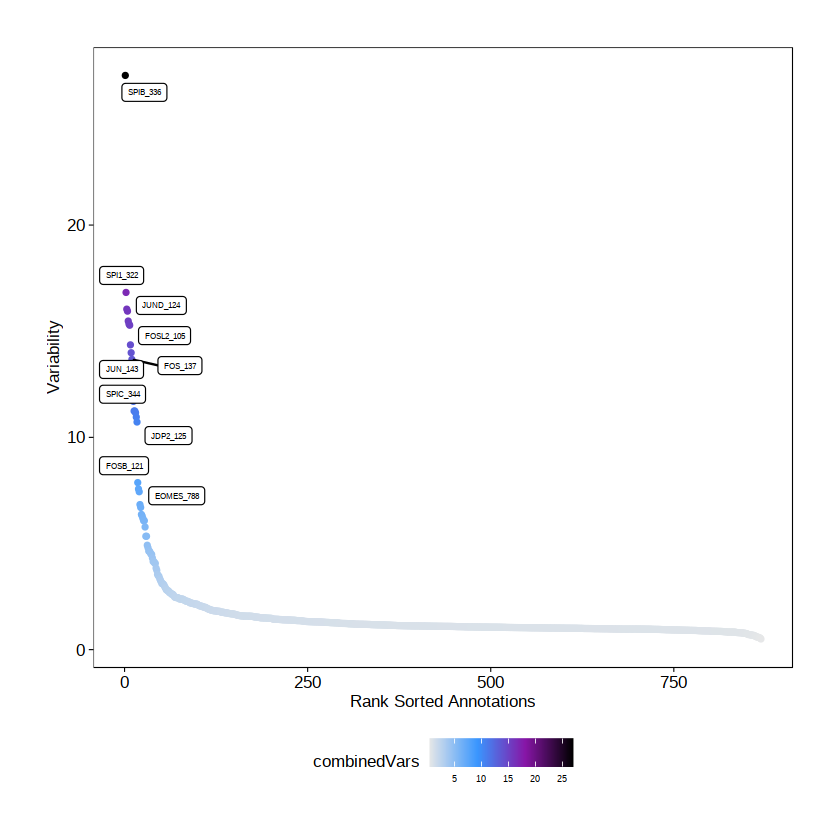

In [53]:
plotVarDev

假如想提取部分motif用于下游分析，就需要用到getFeatures()函数。并使用paste(motifs, collapse="|")语句会以"逻辑或"连接所有motifs里的值，用于选择给定的motif。

In [55]:
motifs <- c("GATA1", "CEBPA")
markerMotifs <- getFeatures(proj, select = paste(motifs, collapse="|"), useMatrix = "MotifMatrix")
markerMotifs

[1] "z:GATA1_383"          "z:CEBPA_155"          "deviations:GATA1_383"
[4] "deviations:CEBPA_155"

正如之前所提到的，MotifMatrix的seqnames包含z-scores(z:)和deviations(deviations:)。为了只提取对应特征的z-scores， 我们需要用到grep。此外，在之前的选择中由于"EBF1"会匹配到"SREBF1"，而后者并不是我们所需要的，因此我们还需要一步过滤。ArchR提供了%ni表达式，它是R提供的%ni%的反义词，表示反向选择。

In [56]:
markerMotifs <- grep("z:", markerMotifs, value = TRUE)

markerMotifs

[1] "z:GATA1_383" "z:CEBPA_155"

既然，我们已经有了我们感兴趣的特征，我们可以为每个cluster绘制chromVAR偏离得分。注，我们提供的是之前基因得分分析里计算的推断权重。考虑到scATAC-seq数据的稀疏性，推断权重利用邻近细胞对信号进行平滑处理。

Getting ImputeWeights

No imputeWeights found, returning NULL

Getting Matrix Values...

2022-08-24 04:52:40 : 

1 


1 
2 


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Picking joint bandwidth of 0.248

Picking joint bandwidth of 0.492



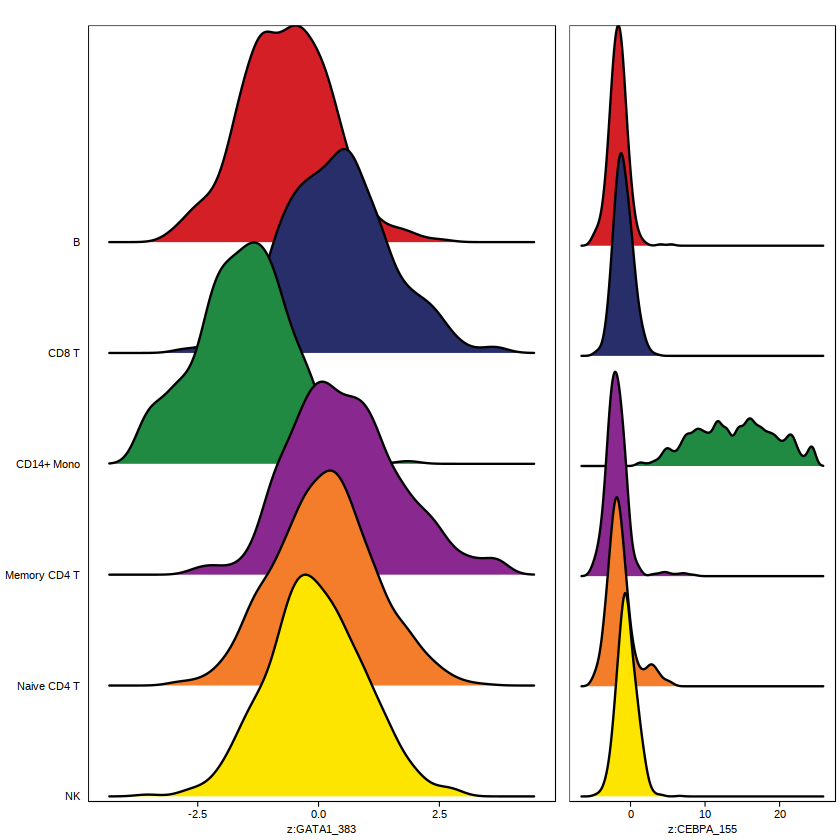

In [59]:
p <- plotGroups(ArchRProj = proj, 
  groupBy = "celltype", 
  colorBy = "MotifMatrix", 
  name = markerMotifs,
  imputeWeights = getImputeWeights(proj)
)
#使用cowplot将不同的moitfs的分布组合在一张图中
p2 <- lapply(seq_along(p), function(x){
  if(x != 1){
    p[[x]] + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6) +
    theme(plot.margin = unit(c(0.1, 0.1, 0.1, 0.1), "cm")) +
    theme(
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank(),
        axis.title.y=element_blank()
    ) + ylab("")
  }else{
    p[[x]] + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6) +
    theme(plot.margin = unit(c(0.1, 0.1, 0.1, 0.1), "cm")) +
    theme(
        axis.ticks.y=element_blank(),
        axis.title.y=element_blank()
    ) + ylab("")
  }
})
do.call(cowplot::plot_grid, c(list(nrow = 1, rel_widths = c(2, rep(1, length(p2) - 1))),p2))

除了检查z-scores的分布，我们也可以和之前展示基因得分一样将z-scores在UMAP嵌入图中进行展示

Getting ImputeWeights

No imputeWeights found, returning NULL

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-45f6f613b7b-Date-2022-08-24_Time-04-53-10.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = MotifMatrix

Getting Matrix Values...

2022-08-24 04:53:11 : 

1 


Plotting Embedding

1 
2 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-45f6f613b7b-Date-2022-08-24_Time-04-53-10.log

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


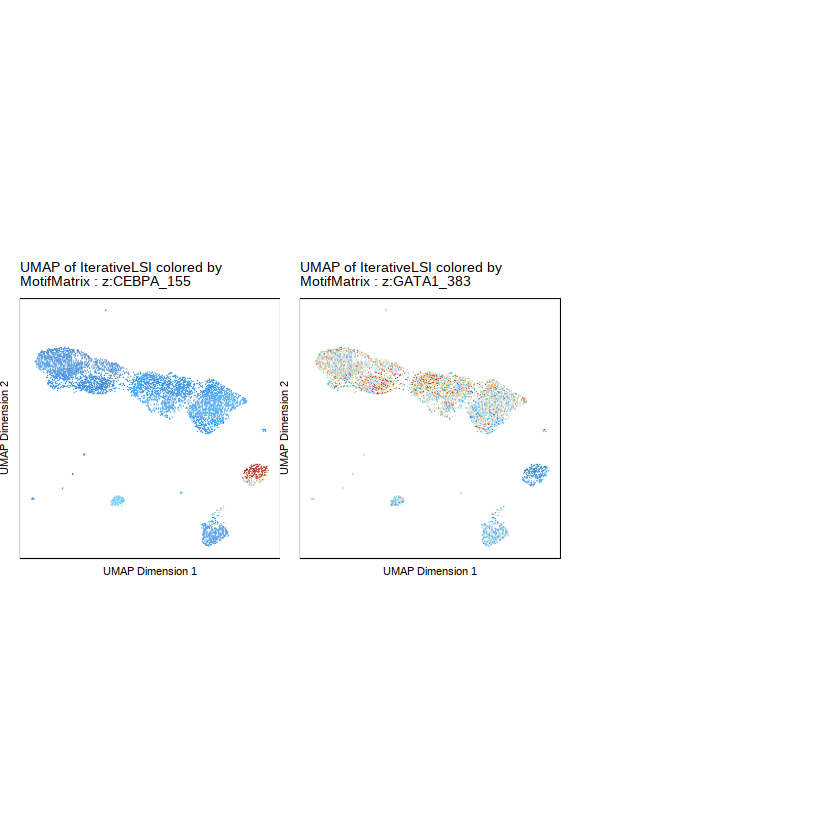

In [61]:
p <- plotEmbedding(
    ArchRProj = proj, 
    colorBy = "MotifMatrix", 
    name = sort(markerMotifs), 
    embedding = "UMAP",
    imputeWeights = getImputeWeights(proj)
)
#可以使用cowplot将motif UMAP放在一张图上展示
p2 <- lapply(p, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6.5) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})
do.call(cowplot::plot_grid, c(list(ncol = 3),p2))

为了比较TF deviation z-scores和根据对应TF基因的基因得分推断的基因表达量，我们可以把这两者画在同一个UMAP中。

Getting ImputeWeights

No imputeWeights found, returning NULL

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-45f68166c0f-Date-2022-08-24_Time-04-54-00.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2022-08-24 04:54:00 : 

1 


Plotting Embedding

1 
2 
3 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-45f68166c0f-Date-2022-08-24_Time-04-54-00.log

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


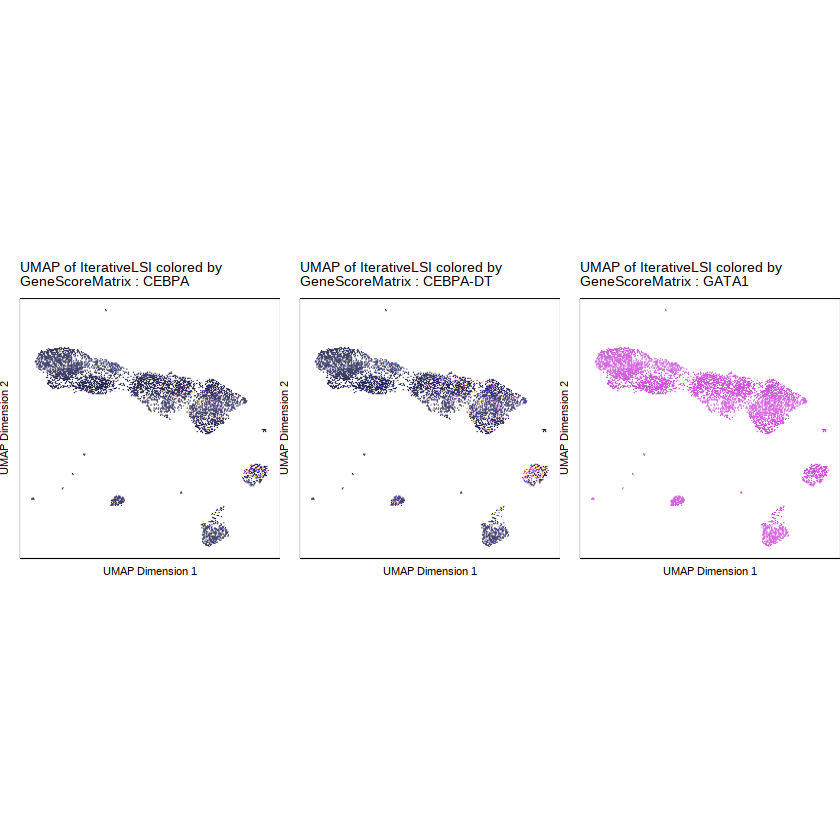

In [63]:
markerRNA <- getFeatures(proj, select = paste(motifs, collapse="|"), useMatrix = "GeneScoreMatrix")

# 获取GeneScoreMatrix
p <- plotEmbedding(
    ArchRProj = proj, 
    colorBy = "GeneScoreMatrix", 
    name = sort(markerRNA), 
    embedding = "UMAP",
    imputeWeights = getImputeWeights(proj)
)
# 同时处理的多个图
p2 <- lapply(p, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6.5) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})
#可以使用cowplot将gene activity score的图放在一张图上展示拼图
do.call(cowplot::plot_grid, c(list(ncol = 3),p2))

之前将对应的scRNA-seq数据和scATAC-seq数据进行了关联，我们也可以在UMAP图上绘制每个TF对应的基因表达量。

In [64]:
markerRNA <- getFeatures(proj, select = paste(motifs, collapse="|"), useMatrix = "GeneIntegrationMatrix")
markerRNA <- markerRNA[markerRNA %ni% c("SREBF1","CEBPA-DT")]
p <- plotEmbedding(
    ArchRProj = proj, 
    colorBy = "GeneIntegrationMatrix", 
    name = sort(markerRNA), 
    embedding = "UMAP",
    continuousSet = "blueYellow",
    imputeWeights = getImputeWeights(proj)
)
p2 <- lapply(p, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6.5) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})
do.call(cowplot::plot_grid, c(list(ncol = 3),p2))

ERROR: Error in h5read(ArrowFile, paste0(subGroup, "/Info/FeatureDF")): Object 'GeneIntegrationMatrix/Info/FeatureDF' does not exist in this HDF5 file.


## 4. ArchR的足迹分析

转录因子(Transcripts factor, TF)足迹分析使得我们能够预测特定位点中TF的精确结合位置。这是因为该位置被TF结合避免了转座酶的切割，而TF结合位点的邻近位置处于开放状态。

<center>
<img src="https://www.archrproject.com/bookdown/images/footprintingSchematic.png"  width="439">
</center>

理想情况下，TF足迹分析需要在单个位置上分析从而确定TF的准确结合位置。但实际上，这需要非常高的测序深度，甚至超过bulk ATAC-seq或者scATAC-seq的所有数据。为了解决这个问题，我们可以把和待预测的TF结合相关的Tn5插入位置进行合并。例如，我们可以提取所有包含CTCF motif的peak，制作一个全基因组的CTCF的聚合TF足迹。

为了保证足迹的可靠性，我们需要确保能够可靠的预测出目标TF所对应的结合位点。ArchR使用自带的`addMotifAnnotations()`函数对peak区域进行搜索，寻找能够匹配的DNA序列。考虑到motif的简并性，无法保证每个motif都有足够的peak。添加到ArchRProject的motif注释以二值矩阵表示(0=无motif, 1=有motif)。一旦你有了这些motif注释，ArchR使用getFootPrints()函数分析足迹，它以一个ArchRProject对象和一个GenomicRanges对象(记录motif的位置)作为输入。可以使用`getPositions()`函数从ArchRProject中提取这些位置。之后足迹可以使用`plotFootprints()`函数可视化。

更重要的是，ArchR的足迹分析能够抵消已知的Tn5插入序列偏好性。ArchR使用一个hexmer位置频率矩阵和一个目标Tn5插入位置上的k-mer频率矩阵来实现该功能。

<img src="https://www.archrproject.com/bookdown/images/footprintingMethods.png" width=800>

### 4.1 motif 足迹分析

在足迹分析过程中，我们需要做的第一件事是获取相关motif的位置，可使用`getPositions()`函数进行调取。

In [65]:
motifPositions <- getPositions(proj)
motifPositions
# motifPositions 为一个GRangesList对象，每个TF motif以不同的GRanges对象进行区分

GRangesList object of length 869:
$TFAP2B_1
GRanges object with 10799 ranges and 1 metadata column:
          seqnames              ranges strand |     score
             <Rle>           <IRanges>  <Rle> | <numeric>
      [1]     chr1       960622-960633      + |   7.97902
      [2]     chr1       976383-976394      - |   8.06512
      [3]     chr1     1059648-1059659      - |   8.21117
      [4]     chr1     1116094-1116105      + |   8.74581
      [5]     chr1     1116094-1116105      - |   8.27709
      ...      ...                 ...    ... .       ...
  [10795]     chrX 154762826-154762837      + |   8.20889
  [10796]     chrX 155071293-155071304      + |   8.78953
  [10797]     chrX 155071293-155071304      - |   8.01518
  [10798]     chrX 155578023-155578034      + |   9.46576
  [10799]     chrX 155578023-155578034      - |  10.50104
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

...
<868 more elements>

In [66]:
# 提取部分感兴趣的TF motifs用于展示
motifs <- c("GATA1", "CEBPA")
markerMotifs <- unlist(lapply(motifs, function(x) grep(x, names(motifPositions), value = TRUE)))

markerMotifs

[1] "GATA1_383" "CEBPA_155"

为了准确找到TF足迹，我们需要大量的reads。因此，细胞需要进行分组生成拟bulk ATAC-seq才能用于TF足迹分析。这些拟bulk ATAC-s之前在peak calling时已经使用`addGroupCoverages()`函数生成。 如果没有在ArchRProject添加，则运行如下命令

In [68]:
#proj <- addGroupCoverages(ArchRProj = proj, groupBy = "celltype")

在计算分组覆盖度后，我们可以为之前getFootprints()挑选的一组标记motif计算足迹。即便ArchR已经优化了足迹分析流程，我们也建议先对一部分motif分析足迹，而不是直接分析所有motif。 我们通过positions参数来选择motif。

In [69]:
seFoot <- getFootprints(
  ArchRProj = proj, 
  positions = motifPositions[markerMotifs], 
  groupBy = "celltype"
)

ArchR logging to : ArchRLogs/ArchR-getFootprints-45fdeb88ee-Date-2022-08-24_Time-05-01-35.log
If there is an issue, please report to github with logFile!

2022-08-24 05:01:35 : Computing Kmer Bias Table, 0.002 mins elapsed.

2022-08-24 05:01:38 : Finished Computing Kmer Tables, 0.041 mins elapsed.

2022-08-24 05:01:38 : Computing Footprints, 0.043 mins elapsed.

2022-08-24 05:01:43 : Computing Footprints Bias, 0.122 mins elapsed.

2022-08-24 05:01:47 : Summarizing Footprints, 0.188 mins elapsed.



### 4.2 Tn5插入偏好性标准化

使用ATAC-seq数据分析TF足迹的一大挑战就是Tn5转座酶的插入序列偏好性，这会导致TF足迹的错误分类。为了降低Tn5插入偏好性的影响，ArchR识别每个Tn5插入位置附近的k-mer序列(k由用户提供，默认是6).

对于该项分析，ArchR为每个拟bulk-seq识别单碱基分辨率的Tn5插入位点，将这些1-bp位点调整为k-bp窗口（-k/2和+（k/2-1）bp），然后使用Biostrings包中的oligonucleotidefrequency(w=k, simplify.as="collapse")函数创建k-mer频率表。然后，ArchR使用与BSgenome相关的基因组文件，以相同的函数计算出全基因组范围预期的k-mers。

为了计算拟混池足迹的插入偏差，ArchR创建了一个k-mer频率矩阵，该矩阵表示为从motif中心到窗口+/-N bp（用户定义，默认为250 bp）的所有可能k-mer。然后，遍历每个motif位点，ArchR将定位的k-mer填充到k-mer频率矩阵中。然后在全基因组范围内计算每个motif位置。利用样本的k-mer频率表，ArchR可以通过将k-mer位置频率表乘以观察/期望 Tn5 k-mer频率来计算预期的Tn5插入。

#### 4.2.1 去除Tn5偏好性
一个标准化方式就是从足迹信号中减去Tn5偏好。该标准化方法通过设置plotFootprints()的normMethod = "Subtract"实现

In [70]:
plotFootprints(
  seFoot = seFoot,
  ArchRProj = proj, 
  normMethod = "Subtract",
  plotName = "Footprints-Subtract-Bias",
  addDOC = FALSE,
  smoothWindow = 5
)

ArchR logging to : ArchRLogs/ArchR-plotFootprints-45f59d47958-Date-2022-08-24_Time-05-02-32.log
If there is an issue, please report to github with logFile!

2022-08-24 05:02:32 : Plotting Footprint : GATA1_383 (1 of 2), 0.001 mins elapsed.

Applying smoothing window to footprint

Normalizing by flanking regions

NormMethod = Subtract

2022-08-24 05:02:33 : Plotting Footprint : CEBPA_155 (2 of 2), 0.02 mins elapsed.

Applying smoothing window to footprint

Normalizing by flanking regions

NormMethod = Subtract

ArchR logging successful to : ArchRLogs/ArchR-plotFootprints-45f59d47958-Date-2022-08-24_Time-05-02-32.log



这些图会默认保存在`ArchRProject`的`outputDirectory`。如果你需要绘制所有motif, 可以将其返回为ggplot2对象，需要注意这个ggplot对象会非常大。下面是一个从motif足迹中减去Tn5偏好信号的结果

#### 4.2.2 除以Tn5偏好
第二种标准化方法就是将足迹除以Tn5偏好信号。该标准化方法通过设置plotFootprints()的normMethod = "Divide"实现

In [72]:
plotFootprints(
  seFoot = seFoot,
  ArchRProj = proj, 
  normMethod = "Divide",
  plotName = "Footprints-Divide-Bias",
  addDOC = FALSE,
  smoothWindow = 5
)

ArchR logging to : ArchRLogs/ArchR-plotFootprints-45f3d3f4065-Date-2022-08-24_Time-05-05-47.log
If there is an issue, please report to github with logFile!

2022-08-24 05:05:47 : Plotting Footprint : GATA1_383 (1 of 2), 0.001 mins elapsed.

Applying smoothing window to footprint

Normalizing by flanking regions

NormMethod = Divide

2022-08-24 05:05:48 : Plotting Footprint : CEBPA_155 (2 of 2), 0.019 mins elapsed.

Applying smoothing window to footprint

Normalizing by flanking regions

NormMethod = Divide

ArchR logging successful to : ArchRLogs/ArchR-plotFootprints-45f3d3f4065-Date-2022-08-24_Time-05-05-47.log



#### 4.2.3 无Tn5偏好标准化的足迹
可以通过设置plotFootprints()的normMethod = "None"来省去标准化。


### 4.3 特征足迹
除了motif足迹分析，ArchR还允许用户分析任意定义的特征数据集。为了对功能进行说明，我们将会使用plotFootprints()函数创建TSS插入谱(在之前数据质量控制一节中引入)。一个TSS插入谱本质上就是特殊的足迹。

我们在之前小节讨论过，足迹会用到来源于拟混池重复的分组覆盖文件。我们在之前peak鉴定时创建过这些文件。如果你没有在ArchRProject加入分组覆盖信息, 那么需要运行如下代码

In [ ]:
#proj <- addGroupCoverages(ArchRProj = proj, groupBy = "celltype")

我们接着创建一个没有经过Tn5偏好性校正的TSS插入谱。和之前分析一个主要不同是，我们设置了flank=2000, 将TSS向前向后分别延伸2000 bp.

In [73]:
seTSS <- getFootprints(
  ArchRProj = proj, 
  positions = GRangesList(TSS = getTSS(proj)), 
  groupBy = "celltype",
  flank = 2000
)
#plotFootprints()对每个细胞分组绘制TSS插入谱。
plotFootprints(
  seFoot = seTSS,
  ArchRProj = proj, 
  normMethod = "None",
  plotName = "TSS-No-Normalization",
  addDOC = FALSE,
  flank = 2000,
  flankNorm = 100
)   

ArchR logging to : ArchRLogs/ArchR-getFootprints-45f79ff1524-Date-2022-08-24_Time-05-06-43.log
If there is an issue, please report to github with logFile!

2022-08-24 05:06:43 : Computing Kmer Bias Table, 0.002 mins elapsed.

2022-08-24 05:07:50 : Finished Computing Kmer Tables, 1.117 mins elapsed.

2022-08-24 05:07:50 : Computing Footprints, 1.118 mins elapsed.

2022-08-24 05:07:59 : Computing Footprints Bias, 1.273 mins elapsed.

2022-08-24 05:08:04 : Summarizing Footprints, 1.355 mins elapsed.

ArchR logging to : ArchRLogs/ArchR-plotFootprints-45f5b5c4a00-Date-2022-08-24_Time-05-08-06.log
If there is an issue, please report to github with logFile!

2022-08-24 05:08:06 : Plotting Footprint : TSS (1 of 1), 0.001 mins elapsed.

Normalizing by flanking regions

NormMethod = None

ArchR logging successful to : ArchRLogs/ArchR-plotFootprints-45f5b5c4a00-Date-2022-08-24_Time-05-08-06.log



## 5. 使用ArchR进行整合分析
ArchR的一个优势能够整合多种水平的信息从而提供新的洞见。我们可以只用ATAC-seq数据进行分析，如识别peak之间的共开放性来预测调控相互作用，或整合scRNA-seq数据，如通过peak-基因的连锁分析预测增性子活性。无论是哪种情况，ArchR都可以很容易地从scATAC seq数据中获得更深入的见解。

### 5.1 创建细胞低重叠聚集
ArchR能方便许多特征间相关性的分析。在这些相关分析中，使用稀疏的单细胞数据进行这些计算会导致大量的噪声。为规避这一挑战，我们采用了一种由Cicero引入的方法，在这些分析之前创建单细胞的低重叠聚集。我们过滤与任何其他聚集重叠超过80%的聚集以减少偏差。同时为提升该方法的速度，我们开发了一个优化的迭代重叠检查流程，借由"Rcpp"包通过C++实现了快速特征相关性运算。在ArchR中，这些优化方法被用于计算peak共开放性、peak-基因连锁和其他连锁分析。这些低重叠聚集运算都是在内部完成，为清楚起见，我们先在这里对其介绍。

### 5.2 ArchR共开放分析
共开放是多个单细胞中两个peak之间开放性的相关性。换句话说，当peak A在某个单细胞中是开放状态时，peak B通常也是开放状态。下图可以直观地说明了这一概念，说明增强子E3通常与启动子P是共开放的。
<center>
<img src="https://www.archrproject.com/bookdown/images/ArchR_Coaccessibility.png" width= 600>
</center>

有一点需要注意，共开放分析找到的peak通常都是细胞类型特异的peak。这是因为这些peak在一种细胞类型中都是开放的，而另一种细胞类型通常都是关闭的。虽然这些peak之间有很强的相关性，但是不意味着这些peak之间存在调控关系。

在ArchR中，我们使用addCoAccessibility()函数计算共开放性，计算结束得到的开放性信息保存在ArchRProject中


In [74]:
proj <- addCoAccessibility(
    ArchRProj = proj,
    reducedDims = "IterativeLSI"
)   

ArchR logging to : ArchRLogs/ArchR-addCoAccessibility-45f54d1d6c8-Date-2022-08-24_Time-05-08-29.log
If there is an issue, please report to github with logFile!

2022-08-24 05:08:29 : Computing KNN, 0.001 mins elapsed.

2022-08-24 05:08:29 : Identifying Non-Overlapping KNN pairs, 0.003 mins elapsed.

2022-08-24 05:08:31 : Identified 484 Groupings!, 0.041 mins elapsed.

2022-08-24 05:08:32 : Computing Co-Accessibility chr1 (1 of 23), 0.052 mins elapsed.

2022-08-24 05:08:37 : Computing Co-Accessibility chr2 (2 of 23), 0.128 mins elapsed.

2022-08-24 05:08:40 : Computing Co-Accessibility chr3 (3 of 23), 0.194 mins elapsed.

2022-08-24 05:08:44 : Computing Co-Accessibility chr4 (4 of 23), 0.252 mins elapsed.

2022-08-24 05:08:47 : Computing Co-Accessibility chr5 (5 of 23), 0.303 mins elapsed.

2022-08-24 05:08:50 : Computing Co-Accessibility chr6 (6 of 23), 0.358 mins elapsed.

2022-08-24 05:08:54 : Computing Co-Accessibility chr7 (7 of 23), 0.418 mins elapsed.

2022-08-24 05:08:57 : Compu

使用getCoAccessibility()函数可以从ArchRProject对象中提取共开放性信息，当设置returnLoops=FALSE时会返回一个DataFrame对象。

In [76]:

cA <- getCoAccessibility(
    ArchRProj = proj,
    corCutOff = 0.5,
    resolution = 1,
    returnLoops = FALSE
)
cA
# 该DataFrame对象包含几个重要的信息。queryHits和subjectHits列记录的是两个存在相关性的peak的索引。correlation则是两个peak之间的开放状态相关的数值。

DataFrame with 186640 rows and 11 columns
       queryHits subjectHits seqnames correlation Variability1 Variability2
       <integer>   <integer>    <Rle>   <numeric>    <numeric>    <numeric>
1              1           8     chr1    0.739104  0.003736620  0.001370062
2              8           1     chr1    0.739104  0.001370062  0.003736620
3              8          11     chr1    0.584619  0.001370062  0.000178814
4              8          18     chr1    0.563333  0.001370062  0.004432400
5             11           8     chr1    0.584619  0.000178814  0.001370062
...          ...         ...      ...         ...          ...          ...
186636     95264       95251     chrX    0.662158  0.004458026  0.029946658
186637     95264       95252     chrX    0.543205  0.004458026  0.026364550
186638     95264       95253     chrX    0.644927  0.004458026  0.046991221
186639     95287       95288     chrX    0.857601  0.000808645  0.001119095
186640     95288       95287     chrX    0.857

这个共开放DataFrame还有一个元数据成员，包含一个相关peak的GRanges对象。上面提到的queryHits和subjectHits的索引适用于这个GRanges对象。

In [77]:
metadata(cA)[[1]]


GRanges object with 95289 ranges and 0 metadata columns:
               seqnames              ranges strand
                  <Rle>           <IRanges>  <Rle>
    CD14+ Mono     chr1       817094-817594      *
            NK     chr1       827279-827779      *
   Naive CD4 T     chr1       844399-844899      *
             B     chr1       865525-866025      *
  Memory CD4 T     chr1       869626-870126      *
           ...      ...                 ...    ...
            NK     chrX 155612717-155613217      *
  Memory CD4 T     chrX 155632492-155632992      *
    CD14+ Mono     chrX 155768342-155768842      *
    CD14+ Mono     chrX 155841302-155841802      *
    CD14+ Mono     chrX 155881001-155881501      *
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

如果我们设置retureLoops=TRUE, 那么getCoAccessibility()会以loop track的形式返回共开放数据。在这个GRanges对象中，IRanges的起始和结束对应的是每个存在互作关系中两个共开放peak的位置。resolution参数设置这些loop的碱基对分辨率。当resolution=1时，它会输出连接每个peak中心的loop.


In [ ]:
cA <- getCoAccessibility(
    ArchRProj = projHeme5,
    corCutOff = 0.5,
    resolution = 1,
    returnLoops = TRUE
)
cA[[1]]


如果我们将loops的分辨率调整为resolution = 1000, 这能够避免绘制过多的共开放互作事件。从下面的输出的GRanges对象中，我们可以看到条目少了很多

In [79]:
cA <- getCoAccessibility(
    ArchRProj = proj,
    corCutOff = 0.5,
    resolution = 1000,
    returnLoops = TRUE
)

cA[[1]]


GRanges object with 89513 ranges and 9 metadata columns:
          seqnames              ranges strand | correlation Variability1
             <Rle>           <IRanges>  <Rle> |   <numeric>    <numeric>
      [1]     chr1       817500-906500      * |    0.739104   0.00373662
      [2]     chr1       906500-924500      * |    0.584619   0.00137006
      [3]     chr1      906500-1000500      * |    0.563333   0.00137006
      [4]     chr1     1000500-1038500      * |    0.581058   0.00443240
      [5]     chr1     1040500-1099500      * |    0.501523   0.01800394
      ...      ...                 ...    ... .         ...          ...
  [89509]     chrX 154732500-154810500      * |    0.543205  0.026364550
  [89510]     chrX 154734500-154740500      * |    0.515006  0.046991221
  [89511]     chrX 154734500-154810500      * |    0.644927  0.046991221
  [89512]     chrX 154799500-154802500      * |    0.662764  0.000657393
  [89513]     chrX 155768500-155841500      * |    0.857601  0.0011

#### 5.2.1 在browser track中绘制共开放
当我们在ArchRProject里增加共开放信息后，我们可以用这个信息在基因组浏览器里绘制loop track。具体做法就是在plotBrowserTrack()函数中设置loops参数。我们这里以`getCoAccessibility()`默认参数输出结果为例，即corCutOff = 0.5, resolution = 1000, returnLoops = TRUE

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-45f378513ba-Date-2022-08-24_Time-05-12-43.log
If there is an issue, please report to github with logFile!

2022-08-24 05:12:43 : Validating Region, 0.001 mins elapsed.



GRanges object with 9 ranges and 2 metadata columns:
      seqnames              ranges strand |     gene_id      symbol
         <Rle>           <IRanges>  <Rle> | <character> <character>
  [1]     chr1 207880972-207911402      - |         947        CD34
  [2]     chrX   48786554-48794311      + |        2623       GATA1
  [3]     chr9   36833275-37034185      - |        5079        PAX5
  [4]    chr11   60455752-60470760      + |         931       MS4A1
  [5]     chr5 140631728-140633701      - |         929        CD14
  [6]    chr11 118338954-118342744      - |         915        CD3D
  [7]     chr2   86784610-86808396      - |         925        CD8A
  [8]    chr17   47733244-47746119      + |       30009       TBX21
  [9]     chr5   35852695-35879603      + |        3575        IL7R
  -------
  seqinfo: 24 sequences from hg38 genome


2022-08-24 05:12:43 : Adding Bulk Tracks (1 of 9), 0.002 mins elapsed.

Getting Region From Arrow Files 1 of 1

2022-08-24 05:12:44 : Adding Feature Tracks (1 of 9), 0.011 mins elapsed.

2022-08-24 05:12:44 : Adding Loop Tracks (1 of 9), 0.012 mins elapsed.

2022-08-24 05:12:44 : Adding Gene Tracks (1 of 9), 0.013 mins elapsed.

2022-08-24 05:12:44 : Plotting, 0.016 mins elapsed.

2022-08-24 05:12:45 : Adding Bulk Tracks (2 of 9), 0.028 mins elapsed.

Getting Region From Arrow Files 1 of 1

2022-08-24 05:12:45 : Adding Feature Tracks (2 of 9), 0.034 mins elapsed.

2022-08-24 05:12:45 : Adding Loop Tracks (2 of 9), 0.035 mins elapsed.

2022-08-24 05:12:45 : Adding Gene Tracks (2 of 9), 0.036 mins elapsed.

2022-08-24 05:12:45 : Plotting, 0.039 mins elapsed.

2022-08-24 05:12:46 : Adding Bulk Tracks (3 of 9), 0.049 mins elapsed.

Getting Region From Arrow Files 1 of 1

2022-08-24 05:12:46 : Adding Feature Tracks (3 of 9), 0.055 mins elapsed.

2022-08-24 05:12:47 : Adding Loop Tracks (3 o

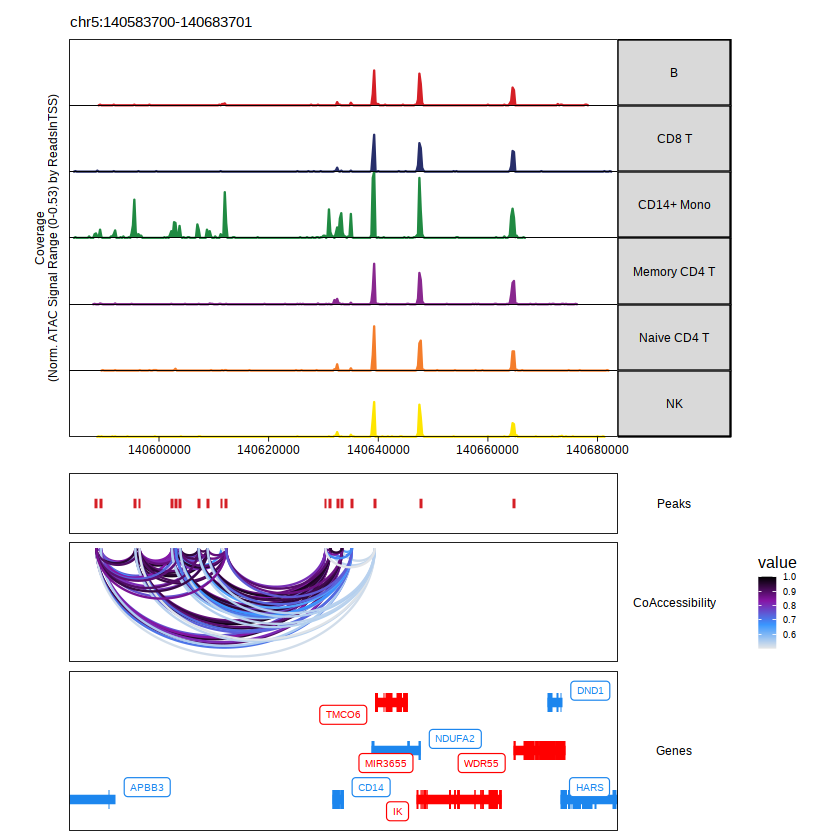

In [82]:
markerGenes  <- c(
    "CD34", #Early Progenitor
    "GATA1", #Erythroid
    "PAX5", "MS4A1", #B-Cell Trajectory
    "CD14", #Monocytes
    "CD3D", "CD8A", "TBX21", "IL7R" #TCells
  )

p <- plotBrowserTrack(
    ArchRProj = proj, 
    groupBy = "celltype", 
    geneSymbol = markerGenes, 
    upstream = 50000,
    downstream = 50000,
    loops = getCoAccessibility(proj)
)

#最后用grid.draw函数绘制结果，通过$选择特定的标记基因。
grid::grid.newpage()
grid::grid.draw(p$CD14)


### 5.3 ArchR中Peak2GeneLinkages分析
和共开放分析类似，ArchR也能分析所谓的"peak-to-gene"关联, 也就是分析peak和基因的相关性。共开放分析和peak-to-gene关联分析的主要不同在于，共开放分析只需要用到ATAC-seq数据，寻找的是peak之间的共开放关系，而peak-to-gene关联分析则会整合scRNA-seq数据，寻找peak开放状态和基因表达量的关系。这其实是相似问题的两种方法。只不过因为peak-to-gene关联分析使用的是scATAC-seq和scRNA-seq数据，我们会认为这个关联更能反应基因调控关系。

在ArchR中，我们使用addPeak2GeneLinks()函数鉴定peak-to-gene的关联。


In [85]:
load('/opt/example/pbmc3k.rda')
#library(Seurat)
#library(SeuratData)
#InstallData("pbmc3k")
#library(pbmc3k.SeuratData)
#data("pbmc3k")

seRNA <- pbmc3k
seRNA@active.assay <- "RNA"
proj <- addGeneIntegrationMatrix(
    ArchRProj = proj,
    useMatrix = "GeneScoreMatrix",
    matrixName = "GeneIntegrationMatrix",
    reducedDims = "IterativeLSI",
    seRNA = seRNA,
    addToArrow = TRUE,
    groupRNA = "seurat_annotations",
    nameCell = "predictedsubCell",
    nameGroup = "predictedsubGroup",
    nameScore = "predictedsubScore",
    force =T
)

ArchR logging to : ArchRLogs/ArchR-addGeneIntegrationMatrix-45f59ef3e04-Date-2022-08-24_Time-05-16-11.log
If there is an issue, please report to github with logFile!

2022-08-24 05:16:11 : Running Seurat's Integration Stuart* et al 2019, 0.001 mins elapsed.

2022-08-24 05:16:11 : Checking ATAC Input, 0.001 mins elapsed.

2022-08-24 05:16:12 : Checking RNA Input, 0.002 mins elapsed.

2022-08-24 05:16:13 : Found 11718 overlapping gene names from gene scores and rna matrix!, 0.024 mins elapsed.

2022-08-24 05:16:13 : Creating Integration Blocks, 0.024 mins elapsed.

2022-08-24 05:16:13 : Prepping Interation Data, 0.024 mins elapsed.

2022-08-24 05:16:13 : Computing Integration in 1 Integration Blocks!, 0 mins elapsed.

2022-08-24 05:16:13 : Block (1 of 1) : Computing Integration, 0 mins elapsed.

2022-08-24 05:16:13 : Block (1 of 1) : Identifying Variable Genes, 0.003 mins elapsed.

2022-08-24 05:16:14 : Block (1 of 1) : Getting GeneScoreMatrix, 0.013 mins elapsed.

2022-08-24 05:16:19 : 

In [87]:
proj <- addPeak2GeneLinks(
    ArchRProj = proj,
    reducedDims = "IterativeLSI"
)

ArchR logging to : ArchRLogs/ArchR-addPeak2GeneLinks-45f4c9e51e6-Date-2022-08-24_Time-06-24-47.log
If there is an issue, please report to github with logFile!

2022-08-24 06:24:47 : Getting Available Matrices, 0.001 mins elapsed.

2022-08-24 06:24:47 : Filtered Low Prediction Score Cells (280 of 6103, 0.046), 0 mins elapsed.

2022-08-24 06:24:47 : Computing KNN, 0.002 mins elapsed.

2022-08-24 06:24:47 : Identifying Non-Overlapping KNN pairs, 0.003 mins elapsed.

2022-08-24 06:24:49 : Identified 484 Groupings!, 0.042 mins elapsed.

2022-08-24 06:24:49 : Getting Group RNA Matrix, 0.043 mins elapsed.

2022-08-24 06:25:08 : Getting Group ATAC Matrix, 0.358 mins elapsed.

2022-08-24 06:25:31 : Normalizing Group Matrices, 0.738 mins elapsed.

2022-08-24 06:25:35 : Finding Peak Gene Pairings, 0.797 mins elapsed.

2022-08-24 06:25:35 : Computing Correlations, 0.801 mins elapsed.

2022-08-24 06:25:43 : Completed Peak2Gene Correlations!, 0.942 mins elapsed.

ArchR logging successful to : ArchRL

我们以上一节类似方式提取这些peak-to-gene的关联信息，只不过这里用的是getPeak2GeneLinks()函数。和之前一样，用户可以设置相关性阈值和关联之间的分辨率。

In [88]:
p2g <- getPeak2GeneLinks(
    ArchRProj = proj,
    corCutOff = 0.45,
    resolution = 1,
    returnLoops = FALSE
)
p2g


DataFrame with 20594 rows and 6 columns
        idxATAC    idxRNA Correlation          FDR  VarQATAC   VarQRNA
      <integer> <integer>   <numeric>    <numeric> <numeric> <numeric>
1             2         1    0.679353  3.58940e-65  0.894143  0.396143
2            20         1    0.606099  1.93991e-48  0.918710  0.396143
3             2         3    0.527123  1.00984e-34  0.894143  0.523810
4            20         3    0.520763  9.02860e-34  0.918710  0.523810
5            46         3    0.792177 1.69150e-103  0.948158  0.523810
...         ...       ...         ...          ...       ...       ...
20590     95252     11705    0.506781  9.47872e-32  0.905634  0.960915
20591     95253     11705    0.657282  1.24627e-59  0.963742  0.960915
20592     95248     11707    0.505721  1.33671e-31  0.684171  0.848524
20593     95247     11709    0.634881  1.80974e-54  0.302113  0.596604
20594     95276     11716    0.452233  1.03027e-24  0.881539  0.359362

当returnLoops=FALSE, 该函数返回一个DataFrame对象，和之前getCoAccessibility()返回的DataFrame相似。主要的不同在于scATAC-seq的索引 peak存放在idxATAC列，而scRNA-seq基因的索引是存放在idxRNA列中
peak-to-gene关联DataFrame对象同样也有一个GRanges对象记录对应peak的metadata。上面提到的idxATAC索引能用于GRanges对象中。

#### 5.3.1 在browser track中绘制peak-to-gene连接
我们可以采用之前共开放分析流程中的相同方法，使用plotBrowserTrack()函数在基因组浏览器上绘制peak-to-gene 连接。


ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-45f7b496318-Date-2022-08-24_Time-08-15-17.log
If there is an issue, please report to github with logFile!

2022-08-24 08:15:17 : Validating Region, 0.001 mins elapsed.



GRanges object with 9 ranges and 2 metadata columns:
      seqnames              ranges strand |     gene_id      symbol
         <Rle>           <IRanges>  <Rle> | <character> <character>
  [1]     chr1 207880972-207911402      - |         947        CD34
  [2]     chrX   48786554-48794311      + |        2623       GATA1
  [3]     chr9   36833275-37034185      - |        5079        PAX5
  [4]    chr11   60455752-60470760      + |         931       MS4A1
  [5]     chr5 140631728-140633701      - |         929        CD14
  [6]    chr11 118338954-118342744      - |         915        CD3D
  [7]     chr2   86784610-86808396      - |         925        CD8A
  [8]    chr17   47733244-47746119      + |       30009       TBX21
  [9]     chr5   35852695-35879603      + |        3575        IL7R
  -------
  seqinfo: 24 sequences from hg38 genome


2022-08-24 08:15:17 : Adding Bulk Tracks (1 of 9), 0.002 mins elapsed.

Getting Region From Arrow Files 1 of 1

2022-08-24 08:15:18 : Adding Feature Tracks (1 of 9), 0.012 mins elapsed.

2022-08-24 08:15:18 : Adding Loop Tracks (1 of 9), 0.013 mins elapsed.

2022-08-24 08:15:18 : Adding Gene Tracks (1 of 9), 0.014 mins elapsed.

2022-08-24 08:15:18 : Plotting, 0.017 mins elapsed.

2022-08-24 08:15:19 : Adding Bulk Tracks (2 of 9), 0.029 mins elapsed.

Getting Region From Arrow Files 1 of 1

2022-08-24 08:15:19 : Adding Feature Tracks (2 of 9), 0.035 mins elapsed.

2022-08-24 08:15:19 : Adding Loop Tracks (2 of 9), 0.036 mins elapsed.

2022-08-24 08:15:19 : Adding Gene Tracks (2 of 9), 0.037 mins elapsed.

2022-08-24 08:15:19 : Plotting, 0.04 mins elapsed.

2022-08-24 08:15:20 : Adding Bulk Tracks (3 of 9), 0.051 mins elapsed.

Getting Region From Arrow Files 1 of 1

2022-08-24 08:15:20 : Adding Feature Tracks (3 of 9), 0.058 mins elapsed.

2022-08-24 08:15:20 : Adding Loop Tracks (3 of

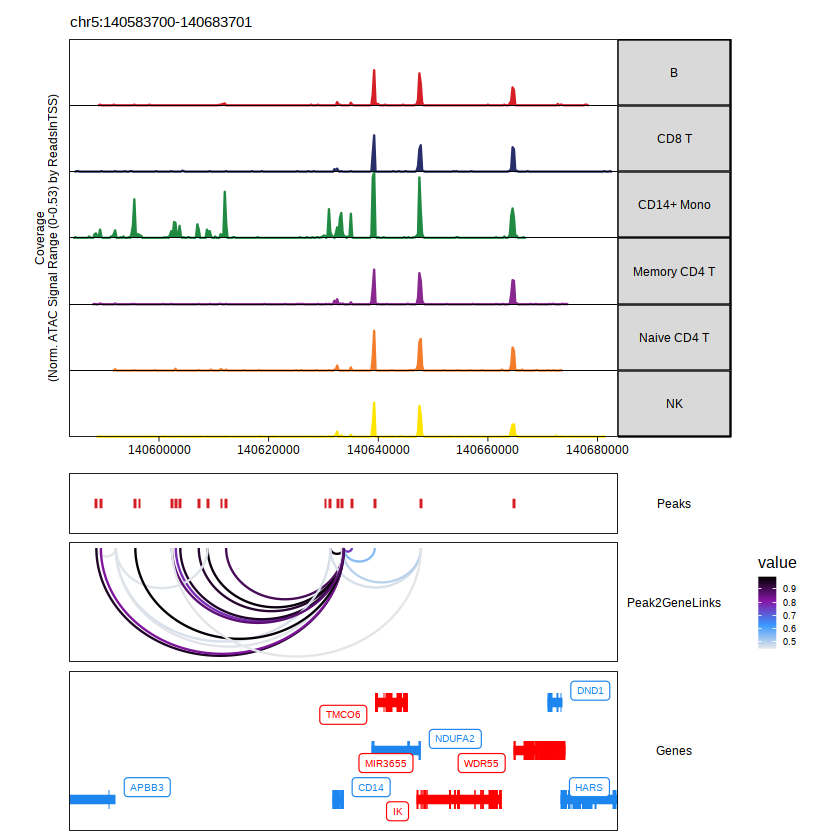

In [91]:
markerGenes  <- c(
    "CD34", #Early Progenitor
    "GATA1", #Erythroid
    "PAX5", "MS4A1", #B-Cell Trajectory
    "CD14", #Monocytes
    "CD3D", "CD8A", "TBX21", "IL7R" #TCells
  )

p <- plotBrowserTrack(
    ArchRProj = proj, 
    groupBy = "celltype", 
    geneSymbol = markerGenes, 
    upstream = 50000,
    downstream = 50000,
    loops = getPeak2GeneLinks(proj)
)
grid::grid.newpage()
grid::grid.draw(p$CD14)

#### 5.3.2 绘制Peak-to-gene连接热图
我们还可以通过绘制peak-to-gene热图的方式展示我们的peak-to-gene连接。热图分为两个部分，一个是scATAC-seq数据，一个是scRNA-seq数据。绘图使用plotPeak2GeneHeatmap()函数


ArchR logging to : ArchRLogs/ArchR-plotPeak2GeneHeatmap-45f3658a061-Date-2022-08-24_Time-08-15-41.log
If there is an issue, please report to github with logFile!

2022-08-24 08:15:45 : Determining KNN Groups!, 0.068 mins elapsed.

2022-08-24 08:15:48 : Ordering Peak2Gene Links!, 0.13 mins elapsed.

Warning message:
“did not converge in 10 iterations”
2022-08-24 08:15:53 : Constructing ATAC Heatmap!, 0.213 mins elapsed.

Adding Annotations..

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

2022-08-24 08:15:54 : Constructing RNA Heatmap!, 0.222 mins elapsed.

Adding Annotations..

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotPeak2GeneHeatmap-45f3658a061-Date-2022-08-24_Time-08-15-41.log



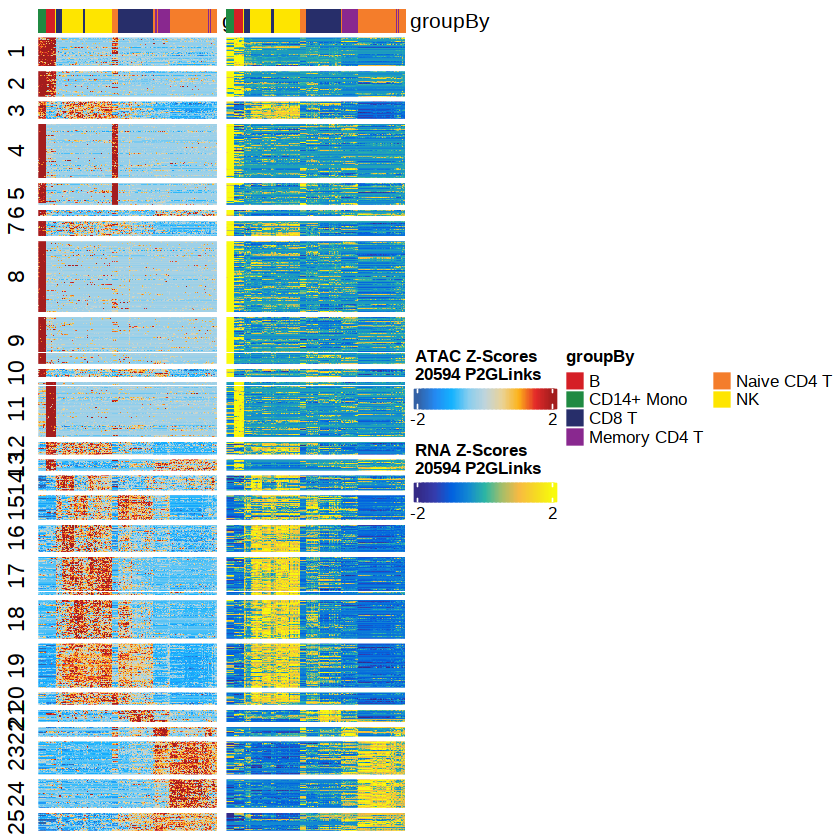

In [92]:
p <- plotPeak2GeneHeatmap(ArchRProj = proj, groupBy = "celltype")
p

### 5.4 正向TF-调控因子鉴定
ATAC-seq还可以无偏好的鉴定TF，这些TF所对应的染色质区域(存在该TF结合的motif DNA序列 )表现出很大改变。此外，从聚集的位置权重矩阵(Position Weight Matrices, PWM)中也能看到这些TF家族在其集合位点上有相似的特征(例如 GATA因子)。
<center>
<img src="https://www.archrproject.com/bookdown/images/GATA_Motif_PWMs.png" width=600>
</center>

这种motif的相似性使得识别特定的TF充满了挑战性，这些TF可能在其预测的结合位点驱动染色质开放状态发生改变。为了规避这一挑战，我们之前用ATAC-seq和RNA-seq来鉴定TF，这些TF的基因表达和对应motif的开放状态呈正相关。我们将这些TF命名为"正向调节因子"。然而，这种分析依赖于匹配的基因表达数据，而这些数据并不是所有实验中都有。ArchR可以识别其推断基因得分与其chromVAR TF偏差z-score相关的TF来克服这种依赖性。实现方式为，ArchR利用低重叠细胞聚集将TF motif的chromVAR deviation z-scroe和TF基因的基因活跃得分相关联。当ArchR整合scRNA-seq时，TF的基因表达可以代替推测的基因活性评分。
#### 5.4.1 第一步: 鉴定偏离TF motif
鉴定正向TF调控因子的第一步就是鉴定存在偏离的TF motif。我们在之前的章节进行过该分析，为所有的motif创建了一个MotifMatrix，记录着chromVAR deviations 和deviation z-scores。使用getGroupSE()函数可以获取基于聚类平均后的数据，返回的是一个SummarizedExperiment.


In [94]:
seGroupMotif <- getGroupSE(ArchRProj = proj, useMatrix = "MotifMatrix", groupBy = "celltype")
seGroupMotif

#因为SummarizedExperiment对象来自于MotifMatrix, 所以它有两个seqnames, "deviation"和"z"，对应chromVAR里原始的偏离值和偏离值的z-scores.

ArchR logging to : ArchRLogs/ArchR-getGroupSE-45f678f0569-Date-2022-08-24_Time-08-32-18.log
If there is an issue, please report to github with logFile!

Getting Group Matrix

2022-08-24 08:32:21 : Successfully Created Group Matrix, 0.053 mins elapsed.

Normalizing by number of Cells

ArchR logging successful to : ArchRLogs/ArchR-getGroupSE-45f678f0569-Date-2022-08-24_Time-08-32-18.log



class: SummarizedExperiment 
dim: 1738 6 
metadata(0):
assays(1): MotifMatrix
rownames(1738): f1 f2 ... f1737 f1738
rowData names(3): seqnames idx name
colnames(6): B CD14+ Mono ... Naive CD4 T NK
colData names(18): TSSEnrichment ReadsInTSS ... FRIP nCells

我们可以从SummarizedExperiment中只提取deviation z-scores.

In [96]:
seZ <- seGroupMotif[rowData(seGroupMotif)$seqnames=="z",]

然后，我们计算该z-score在所有聚类中最大变化值。根据motif在不同聚类中观察到的差异程度，我们可以对其分层。

In [99]:
rowData(seZ)$maxDelta <- lapply(seq_len(ncol(seZ)), function(x){
  rowMaxs(assay(seZ) - assay(seZ)[,x])
}) %>% Reduce("cbind", .) %>% rowMaxs

seZ

class: SummarizedExperiment 
dim: 869 6 
metadata(0):
assays(1): MotifMatrix
rownames(869): f870 f871 ... f1737 f1738
rowData names(4): seqnames idx name maxDelta
colnames(6): B CD14+ Mono ... Naive CD4 T NK
colData names(18): TSSEnrichment ReadsInTSS ... FRIP nCells

#### 5.4.2 第二步: 鉴定相关的TF motif和TF基因得分/表达值
接着我们使用correlateMatrices()函数来获取motif开放状态矩阵和基因活跃矩阵(基因得分或基因表达量)，在这里就是GeneScoreMatrix和MotifMatrix. 它们将用于鉴定一类motif开放状态和其自身基因活跃相关的TF。正如之前所提到，我们使用许多低重叠细胞聚集在低维空间里(对应reducedDims参数)来计算相关性。

In [100]:
corGSM_MM <- correlateMatrices(
    ArchRProj = proj,
    useMatrix1 = "GeneScoreMatrix",
    useMatrix2 = "MotifMatrix",
    reducedDims = "IterativeLSI"
)
corGSM_MM
# 该函数返回一个DataFrame对象，记录着GeneScoreMatrix和MotifMatrix，以及它们在低重叠细胞聚类中的相关性。

ArchR logging to : ArchRLogs/ArchR-correlateMatrices-45f225845f7-Date-2022-08-24_Time-08-35-26.log
If there is an issue, please report to github with logFile!

When accessing features from a matrix of class Sparse.Assays.Matrix it requires 1 seqname!
Continuing with first seqname 'z'!
If confused, try getFeatures(ArchRProj, 'MotifMatrix') to list out available seqnames for input!

2022-08-24 08:35:27 : Testing 869 Mappings!, 0.016 mins elapsed.

2022-08-24 08:35:27 : Computing KNN, 0.016 mins elapsed.

2022-08-24 08:35:27 : Identifying Non-Overlapping KNN pairs, 0.018 mins elapsed.

2022-08-24 08:35:29 : Identified 484 Groupings!, 0.056 mins elapsed.

2022-08-24 08:35:30 : Getting Group Matrix 1, 0.067 mins elapsed.

2022-08-24 08:35:38 : Getting Group Matrix 2, 0.204 mins elapsed.

Some entries in groupMat2 are less than 0, continuing without Log2 Normalization.
Most likely this assay is a deviations matrix.

Getting Correlations...

2022-08-24 08:35:44 : 

Computing Correlation (250 

DataFrame with 869 rows and 14 columns
    GeneScoreMatrix_name MotifMatrix_name         cor        padj        pval
             <character>      <character>   <numeric>   <numeric>   <numeric>
1                   HES4          HES4_95   0.0694932 1.00000e+00 1.26825e-01
2                   HES5          HES5_98   0.0999482 1.00000e+00 2.79005e-02
3                 PRDM16       PRDM16_211  -0.3381859 1.76475e-11 2.05204e-14
4                   TP73         TP73_705   0.3587066 3.29645e-13 3.83308e-16
5               TP73-AS1         TP73_705  -0.2299657 2.69998e-04 3.13951e-07
...                  ...              ...         ...         ...         ...
865                TFDP3        TFDP3_309  0.00254317    1.000000 0.955496985
866               ZNF75D       ZNF75D_272  0.11574697    1.000000 0.010821222
867                 ZIC3         ZIC3_215 -0.16884473    0.163497 0.000190112
868                 SOX3         SOX3_759 -0.05523185    1.000000 0.225173870
869                MECP2 

同样的分析还可以使用GeneIntegrationMatrix, 用于替代GeneScoreMatrix

In [101]:
corGIM_MM <- correlateMatrices(
    ArchRProj = proj,
    useMatrix1 = "GeneIntegrationMatrix",
    useMatrix2 = "MotifMatrix",
    reducedDims = "IterativeLSI"
)

ArchR logging to : ArchRLogs/ArchR-correlateMatrices-45f9a0a382-Date-2022-08-24_Time-09-06-51.log
If there is an issue, please report to github with logFile!

When accessing features from a matrix of class Sparse.Assays.Matrix it requires 1 seqname!
Continuing with first seqname 'z'!
If confused, try getFeatures(ArchRProj, 'MotifMatrix') to list out available seqnames for input!

2022-08-24 09:06:52 : Testing 392 Mappings!, 0.009 mins elapsed.

2022-08-24 09:06:52 : Computing KNN, 0.009 mins elapsed.

2022-08-24 09:06:52 : Identifying Non-Overlapping KNN pairs, 0.01 mins elapsed.

2022-08-24 09:06:54 : Identified 484 Groupings!, 0.051 mins elapsed.

2022-08-24 09:06:55 : Getting Group Matrix 1, 0.061 mins elapsed.

2022-08-24 09:07:04 : Getting Group Matrix 2, 0.209 mins elapsed.

Some entries in groupMat2 are less than 0, continuing without Log2 Normalization.
Most likely this assay is a deviations matrix.

Getting Correlations...

2022-08-24 09:07:08 : 

Computing Correlation (250 of

#### 5.4.3 第三步: 在相关性DataFrame中添加极大偏差值
对于每个相关性分析，我们使用第一步计算的极大偏差值(maximum delta )来注释每个motif

In [102]:
corGSM_MM$maxDelta <- rowData(seZ)[match(corGSM_MM$MotifMatrix_name, rowData(seZ)$name), "maxDelta"]
corGIM_MM$maxDelta <- rowData(seZ)[match(corGIM_MM$MotifMatrix_name, rowData(seZ)$name), "maxDelta"]

#### 5.4.4 第四步: 鉴定正向TF调控因子
我们可以利用所有这些信息来识别正向TF调控因子。在下面的例子中，正向调控因子的标准为

- motif和基因得分（或基因表达）之间的相关性大于0.5
- 调整后的p值小于0.01
- deviation z-score的最大组间差异位于前四分位。
我们应用这些过滤标准，并且做一些文本调整来分离TF名字。


In [103]:
corGSM_MM <- corGSM_MM[order(abs(corGSM_MM$cor), decreasing = TRUE), ]
corGSM_MM <- corGSM_MM[which(!duplicated(gsub("\\-.*","",corGSM_MM[,"MotifMatrix_name"]))), ]
corGSM_MM$TFRegulator <- "NO"
corGSM_MM$TFRegulator[which(corGSM_MM$cor > 0.5 & corGSM_MM$padj < 0.01 & corGSM_MM$maxDelta > quantile(corGSM_MM$maxDelta, 0.75))] <- "YES"
sort(corGSM_MM[corGSM_MM$TFRegulator=="YES",1])

[1] "BCL11A"    "CEBPA-DT"  "CEBPB"     "CEBPD"     "EBF1"      "ELK4"     
 [7] "EOMES"     "ETS1-AS1"  "FOS"       "FOSL2"     "FOXP3"     "GATA3-AS1"
[13] "HDX"       "ID3"       "JUNB"      "LEF1"      "LYL1"      "MAFF"     
[19] "MEF2A"     "MEF2C"     "MITF"      "NFE2"      "PAX5"      "PPARG"    
[25] "RARA-AS1"  "REL"       "RUNX1"     "SMAD1"     "SNAI2"     "SPI1"     
[31] "SPIB"      "TAL2"      "TCF7"      "YY1"       "ZEB1-AS1"

在从基因得分和motif deviation z-scores鉴定到正向TF调控因子后，我们可以在点图中突出展示

Warning message:
“Removed 8 rows containing missing values (geom_point).”


[1] "ATF5"   "CEBPA"  "CEBPB"  "CEBPD"  "CEBPE"  "EOMES"  "FOSL1"  "FOSL2" 
 [9] "IRF4"   "LEF1"   "MAFK"   "MEF2A"  "MEF2C"  "MITF"   "NFE2"   "NR4A1" 
[17] "POU2F2" "RELB"   "RUNX2"  "SPI1"   "SPIB"

Warning message:
“Removed 42 rows containing missing values (geom_point).”


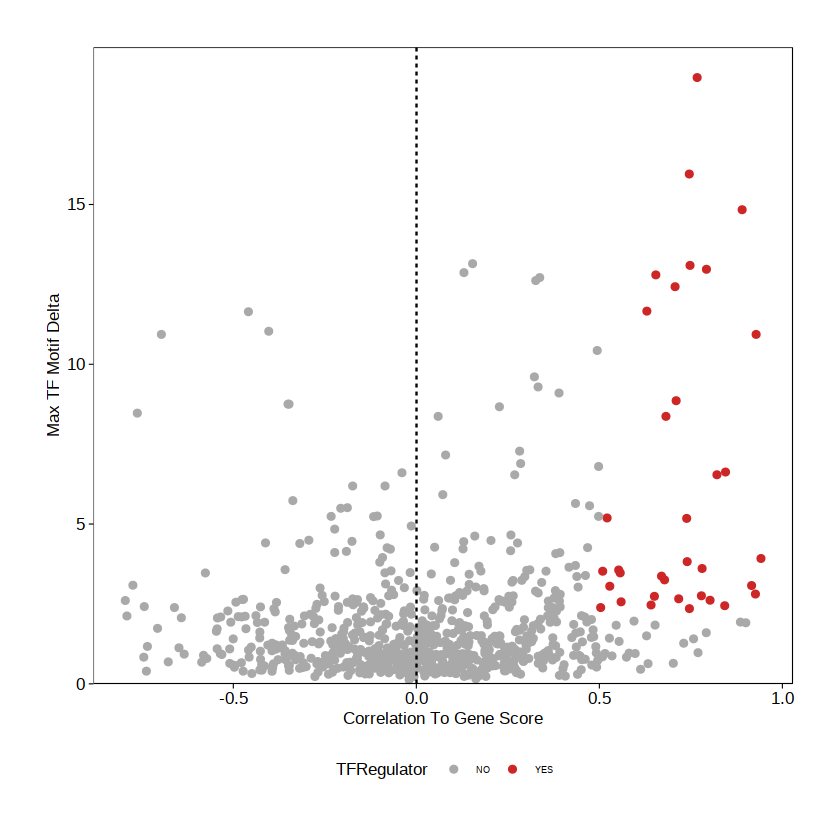

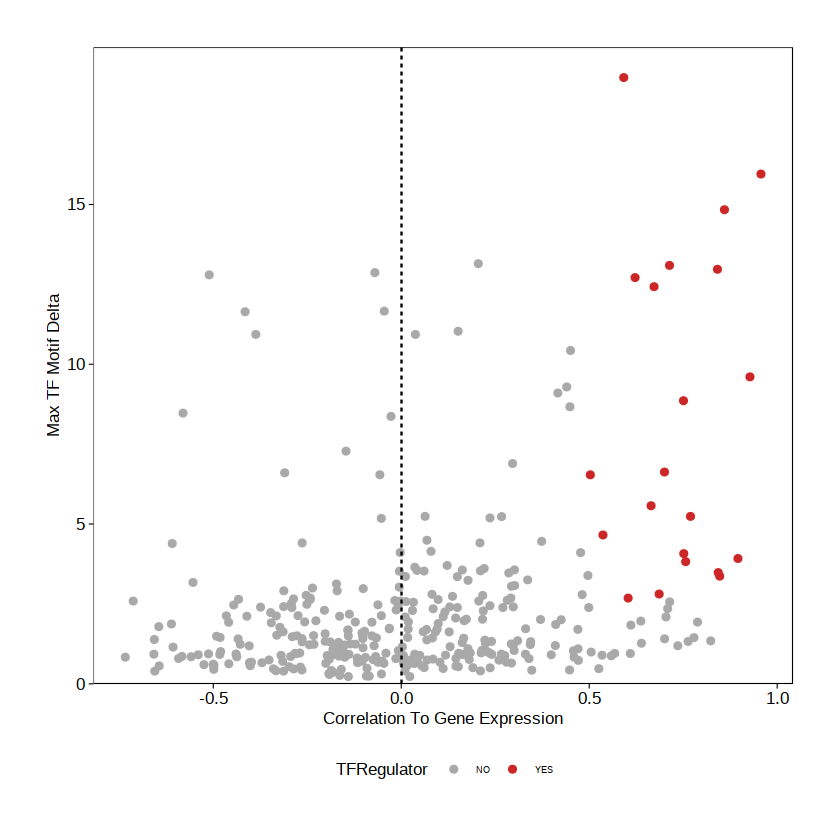

In [104]:
p <- ggplot(data.frame(corGSM_MM), aes(cor, maxDelta, color = TFRegulator)) +
  geom_point() + 
  theme_ArchR() +
  geom_vline(xintercept = 0, lty = "dashed") + 
  scale_color_manual(values = c("NO"="darkgrey", "YES"="firebrick3")) +
  xlab("Correlation To Gene Score") +
  ylab("Max TF Motif Delta") +
  scale_y_continuous(
    expand = c(0,0), 
    limits = c(0, max(corGSM_MM$maxDelta)*1.05)
  )

p

# 使用相同的分析策略处理GeneIntegrationMatrix
corGIM_MM <- corGIM_MM[order(abs(corGIM_MM$cor), decreasing = TRUE), ]
corGIM_MM <- corGIM_MM[which(!duplicated(gsub("\\-.*","",corGIM_MM[,"MotifMatrix_name"]))), ]
corGIM_MM$TFRegulator <- "NO"
corGIM_MM$TFRegulator[which(corGIM_MM$cor > 0.5 & corGIM_MM$padj < 0.01 & corGIM_MM$maxDelta > quantile(corGIM_MM$maxDelta, 0.75))] <- "YES"
sort(corGIM_MM[corGIM_MM$TFRegulator=="YES",1])

p <- ggplot(data.frame(corGIM_MM), aes(cor, maxDelta, color = TFRegulator)) +
  geom_point() + 
  theme_ArchR() +
  geom_vline(xintercept = 0, lty = "dashed") + 
  scale_color_manual(values = c("NO"="darkgrey", "YES"="firebrick3")) +
  xlab("Correlation To Gene Expression") +
  ylab("Max TF Motif Delta") +
  scale_y_continuous(
    expand = c(0,0), 
    limits = c(0, max(corGIM_MM$maxDelta)*1.05)
  )

p

## 6. 使用ArchR进行轨迹分析
**本实例以PBMC为例不存在发育轨迹 无法进行轨迹分析**
ArchR在ArchRProject中低维子空间对细胞进行排序来创建细胞轨迹，实现伪时间中细胞排序。我们之前已经在二维UMAP子空间中执行了这种排序，但是ArchR改进了这种方法，使其能够在N维子空间（即LSI）内进行对齐。

1.  ArchR需要用户提供一个轨迹描述细胞分组/聚类的大致分化方向。例如，用户提供的细胞编号为HSC, GMP, Monocyte，这表示细胞以干细胞作为起点，然后是祖细胞，最后是分化细胞。这种分化方向信息来自于已有的生物学相关的细胞轨迹发育的背景知识。
2.  ArchR计算每个聚类在N维空间的平均坐标，对于聚类里的每个细胞，计算其相对于平均指标的欧几里得距离，最后只保留前5%的细胞。
3.  ArchR根据轨迹计算cluster i里的每个细胞和cluster i+1平均坐标的距离，根据距离计算拟时间向量。之后依次遍历所有的cluster执行运算。根据每个细胞相对于细胞分组/聚类平均坐标的欧几里得距离，ArchR能够为每个细胞确定N维坐标和它的拟时间值从而成为轨迹的一部分。
4.  ArchR使用smooth.spline函数根据拟时间值讲连续的轨迹拟合到N维坐标中。
5.  ArchR根据欧氏距离最近细胞沿着流形依次将所有细胞对齐到轨迹上。
6.  ArchR将对其后的值缩放到100，并将其保存在ArchRProject中用于下游分析。
ArchR可以根据Arrow文件里的特征创建拟时间趋势矩阵。例如，ArchR可以分析随着拟时间发生变化的TF deviation, 基因得分，整合基因表达量，从而鉴定随着细胞轨迹动态变化的调节因子或调控元素。

- ArchR将细胞沿着细胞轨迹进行分组，组数由用户定义（默认是1/100）
- ArchR使用用户定义平滑滑窗(默认是9/100)对矩阵的特征进行平滑处理(调用data.table::frollmean函数)
- ArchR会返回一个SummarizedExperiment对象，它是一个平滑后的拟时间 X 特征矩阵，用于下游分析。
ArchR还可以根据以下信息对任意两个平滑后拟时间 X 特征矩阵进行关联分析，例如匹配的命名(如chromVAR TF deviations的正向调控因子和基因得分/整合谱)，之前章节提到的利用低重叠细胞聚集的基因组位置重叠方法(例如 peak-to-gene 关联)。最终，ArchR能为细胞轨迹的整合分析提供帮助，解释多组学之间动态调控关系。

### 6.1 髓系轨迹-单核细胞分化
这一节，我们会创建一个细胞估计用以模拟HSC发育成分化后单核细胞的过程。 在开始之前，我们先来检查保存在cellColData中的聚类和之前定义的细胞类型，分别是"Clusters"和"Clusters2"。我们通过UMAP来进行展示，从中找到我们感兴趣的细胞类型。



In [ ]:
p1 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", name = "Clusters", embedding = "UMAP")
p2 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", name = "Clusters2", embedding = "UMAP")
ggAlignPlots(p1, p2, type = "h")

<img src="https://www.archrproject.com/bookdown/images/HemeWalkthrough/PNG/Plot-UMAP-Clusters12-Combined_1.png">

#### 6.1.1 拟时间UMAP和特征单独作图
我们接下来会用到"Clusters2"里面定义的细胞类型。和之前提到的那样，我们会以干细胞("Progenitor")-骨髓祖细胞("GMP")-单核细胞("Mono")这个分化过程创建轨迹。

第一步，我们需要以用一个向量记录轨迹骨干，里面按顺序记录发育各过程中细胞分组的标签。

In [ ]:
trajectory <- c("Progenitor", "GMP", "Mono")

第二步，使用addTrajectory()创建轨迹，并加入到ArchRProject中。我们将其命名为"MyeloidU"。该函数的作用就是在cellColData中新建一列，命名为"MyeloidU"，然后记录每个细胞在轨迹中拟时间值。不在轨迹中的细胞记做NA。

使用plotTrajectory()函数绘制轨迹，它会用UMAP进行可视化，用拟时间值进行上色，箭头标识轨迹的发育方向。非轨迹的细胞会以灰色标识。在这个例子中，使用colorBy = "cellColData"和name="MyeloidU"让ArchR使用cellColData里"MyeloidU"作为拟时间轨迹。参数中trajectory和name都是"MyeloidU"，可能不太容易理解，ArchR根据trajectory来提取细胞，根据name来对细胞进行着色。


In [ ]:
projHeme5 <- addTrajectory(
    ArchRProj = proj, 
    name = "MyeloidU", 
    groupBy = "celltype",
    trajectory = trajectory, 
    embedding = "UMAP", 
    force = TRUE
)

In [ ]:
p <- plotTrajectory(proj, trajectory = "MyeloidU", colorBy = "cellColData", name = "MyeloidU")
p[[1]]

<img src="https://www.archrproject.com/bookdown/images/HemeWalkthrough/PNG/Plot-MyeloidU-Traj-UMAP_1.png" width="468">

In [ ]:
p1 <- plotTrajectory(projHeme5, trajectory = "MyeloidU", colorBy = "GeneScoreMatrix", name = "CEBPB", continuousSet = "horizonExtra")

In [ ]:
p2 <- plotTrajectory(projHeme5, trajectory = "MyeloidU", colorBy = "GeneIntegrationMatrix", name = "CEBPB", continuousSet = "blueYellow")

该plotTrajectory()函数实际上返回相关图的列表。列表中的第一个图是 UMAP 嵌入，按函数调用中指定的颜色着色。并排比较这些 UMAP 图的基因评分和基因表达，我们看到 CEBPB 基因的活性在伪时间轨迹的后期对单核细胞具有高度特异性。

In [ ]:
ggAlignPlots(p1[[1]], p2[[1]], type = "h")

<img src="https://www.archrproject.com/bookdown/images/HemeWalkthrough/PNG/Plot-UMAP-CEBPB-Combined_1.png" width="468">

In [ ]:
ggAlignPlots(p1[[2]], p2[[2]], type = "h")

<img src="https://www.archrproject.com/bookdown/images/HemeWalkthrough/PNG/Plot-UMAP-CEBPB-Combined2_1.png" width="468">

#### 6.1.2伪时间热图
我们可以使用热图在伪时间内可视化许多特征的变化。为此，我们首先ArchRProject使用getTrajectory()将轨迹作为SummarizedExperiment对象返回的函数检索感兴趣的轨迹。useMatrix我们将通过将相应的矩阵传递给参数来为基序、基因评分、基因表达和峰值可访问性创建这些伪时间热图。

In [ ]:
trajMM  <- getTrajectory(ArchRProj = proj, name = "MyeloidU", useMatrix = "MotifMatrix", log2Norm = FALSE)
#useMatrix可使用MotifMatrix GeneScoreMatrix GeneIntegrationMatrix

In [ ]:
p1 <- plotTrajectoryHeatmap(trajMM, pal = paletteContinuous(set = "solarExtra"))

<img src="https://www.archrproject.com/bookdown/images/HemeWalkthrough/PNG/Plot-MyeloidU-Traj-Heatmaps_1.png" width="468">